# Step-1: Import Required Packages

In [72]:
!pip install statsmodels prophet pmdarima -q


#Step-2: Import Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

#Step-2: Upload Data File

In [27]:

from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]


Saving Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv to Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603 (1).csv


#Step-3: Load and Preprocess Data

In [28]:
def load_and_preprocess_data(file_path):

    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    df = df.sort_values('Date').reset_index(drop=True)
    print(f"\nMissing values before cleaning:")
    print(df.isnull().sum())
    df = df.fillna(method='ffill').fillna(method='bfill')
    ridership_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
    df = df[df[ridership_cols].sum(axis=1) > 0]
    df['Total_Ridership'] = df[ridership_cols].sum(axis=1)
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    df['Quarter'] = df['Date'].dt.quarter

    print(f"\nDataset shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Total days: {len(df)}")

    print("\n✓ Data preprocessing completed!")
    return df
df = load_and_preprocess_data(filename)
print("\nFirst 10 rows of data:")
df.head(10)


Missing values before cleaning:
Date             0
Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64

Dataset shape: (1918, 13)
Date range: 2019-07-01 00:00:00 to 2024-09-29 00:00:00
Total days: 1918

✓ Data preprocessing completed!

First 10 rows of data:


Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0 2019-07-01        15987        9962           407        21223    3715   
1 2019-07-02        16895       10656           409        21715    3993   
2 2019-07-03        16613       10658           427        22025    3638   
3 2019-07-04        16604       10445           437        21868    3576   
4 2019-07-05        16040       10532           400        20697    2856   
5 2019-07-06         5214        6141             0         6925       0   
6 2019-07-07         4065        4332             0         5426       0   
7 2019-07-08        13078        9442           422        18848       0   
8 2019-07-09        13835       10550           455        19862       0   
9 2019-07-10        13856       10066           421        19502       0   

   Other  Total_Ridership  DayOfWeek  Month  Year  IsWeekend  Quarter  
0    0.0          51294.0          0      7  2019          0        3  
1    0.0          53668.0          1      7  2019          0        3  
2    0.0          53361.0          2      7  2019          0        3  
3    0.0          52930.0          3      7  2019          0        3  
4    0.0          50525.0          4      7  2019          0        3  
5    0.0          18280.0          5      7  2019          1        3  
6    0.0          13823.0          6      7  2019          1        3  
7    0.0          41790.0          0      7  2019          0        3  
8    1.0          44703.0          1      7  2019          0        3  
9    1.0          43846.0          2      7  2019          0        3

#Step-5: Exploratory Data Analysis


--- BASIC INFO ---
Dataset Shape: (1918, 13)
Date Range: 2019-07-01 to 2024-09-29
Total Days: 1918
Total Records: 1918

--- MISSING VALUES ---
Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
Other           0
dtype: int64
 No missing values detected!

--- SUMMARY STATISTICS ---
        Local Route    Light Rail  Peak Service   Rapid Route       School  \
count   1918.000000   1918.000000   1918.000000   1918.000000  1918.000000   
mean    9891.395203   7195.446298    179.581335  12597.213243  2352.694995   
std     6120.715714   3345.616428    156.532738   6720.494557  2494.766306   
min        1.000000      0.000000      0.000000      0.000000     0.000000   
25%     3044.500000   4463.500000      0.000000   6383.000000     0.000000   
50%    11417.000000   7507.000000    193.000000  13106.500000   567.500000   
75%    15517.500000  10008.250000    313.750000  17924.750000  4914.000000   
max    21070.000000  15154.000000   1029.000000  28678

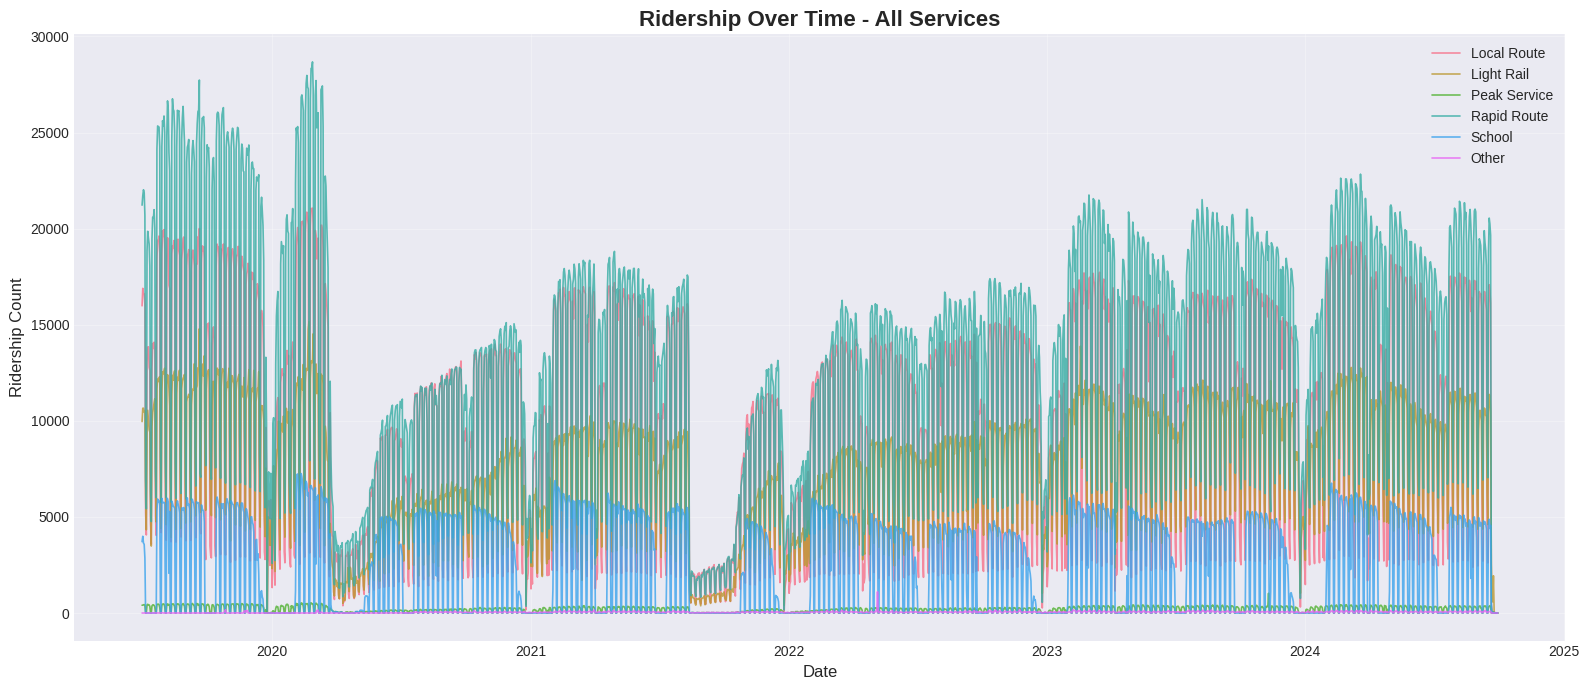


--- Plotting Individual Service Trends ---


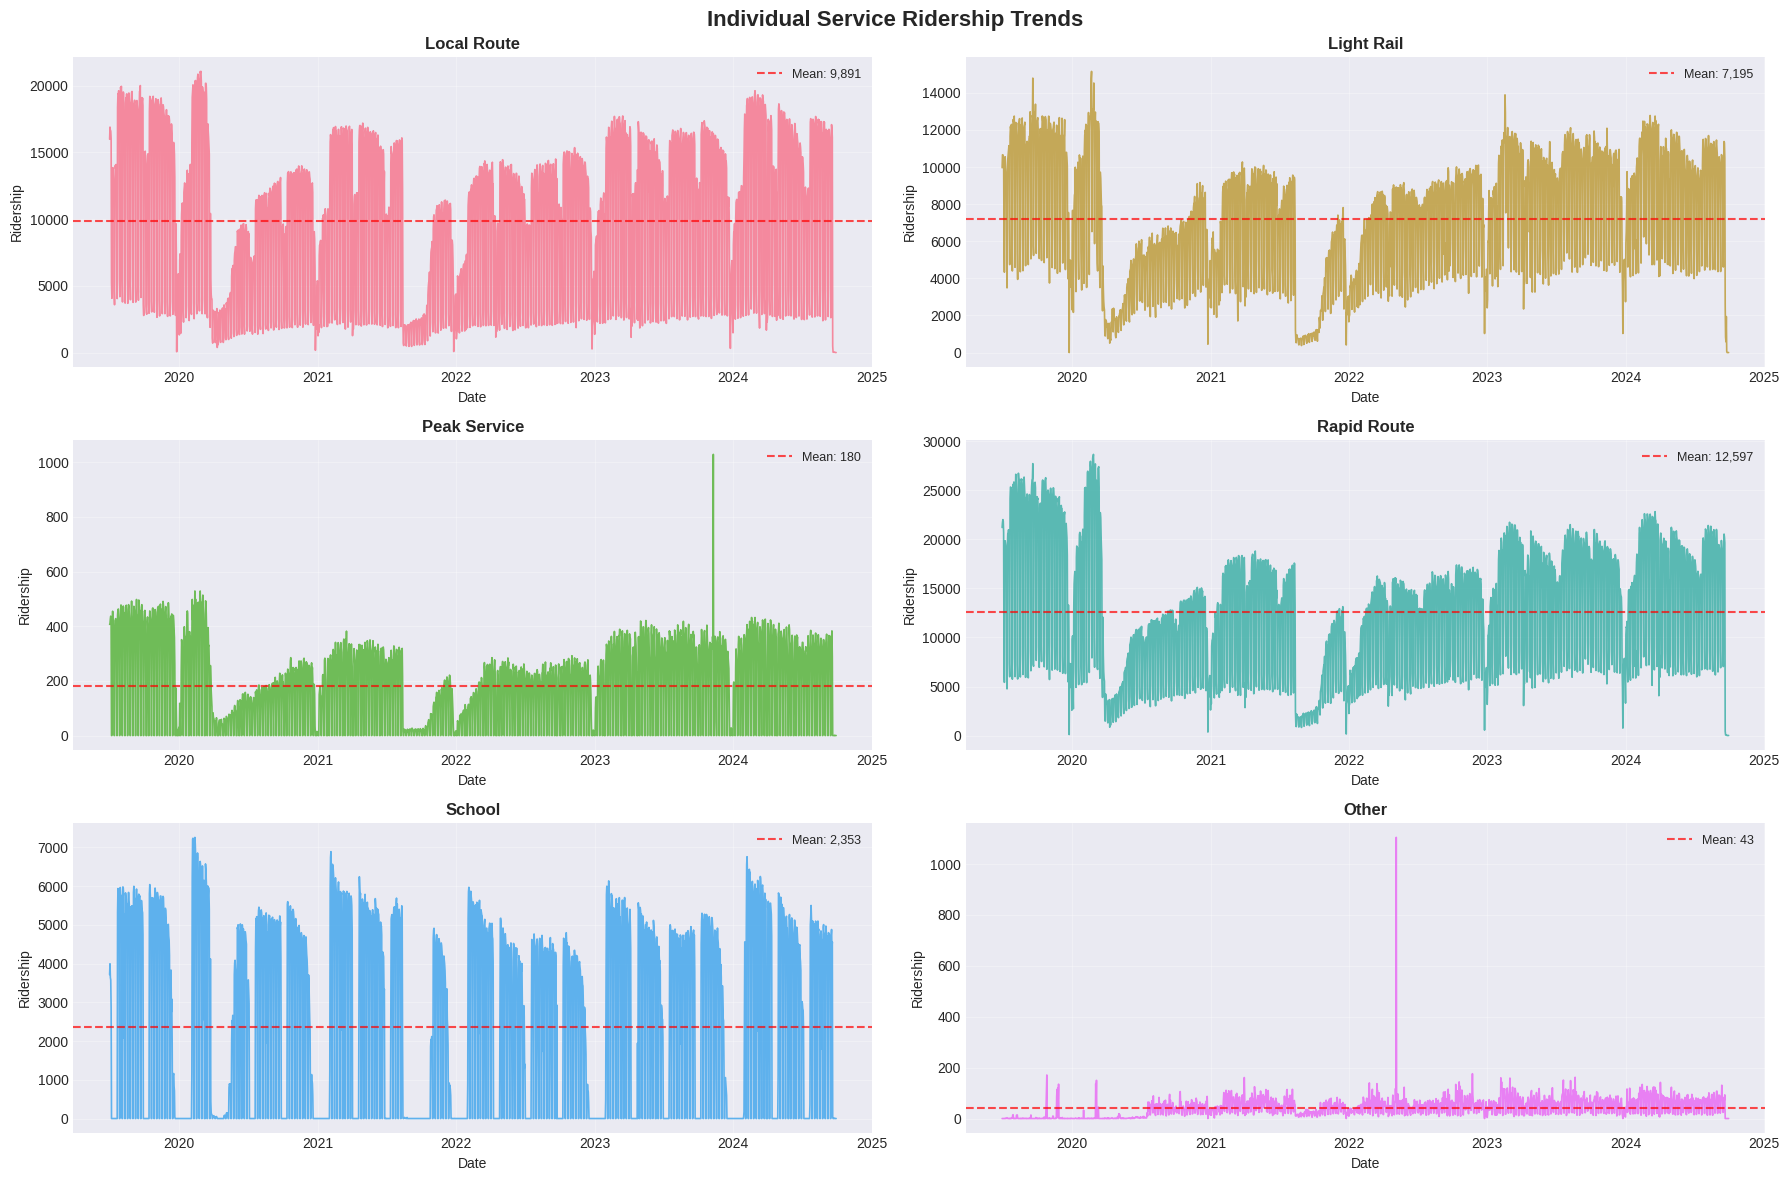


--- CORRELATION ANALYSIS ---
Correlation Matrix:
              Local Route  Light Rail  Peak Service  Rapid Route    School  \
Local Route      1.000000    0.918795      0.944390     0.965122  0.852356   
Light Rail       0.918795    1.000000      0.879347     0.967736  0.685795   
Peak Service     0.944390    0.879347      1.000000     0.944997  0.728795   
Rapid Route      0.965122    0.967736      0.944997     1.000000  0.754290   
School           0.852356    0.685795      0.728795     0.754290  1.000000   
Other            0.471191    0.425295      0.377399     0.380954  0.431021   

                 Other  
Local Route   0.471191  
Light Rail    0.425295  
Peak Service  0.377399  
Rapid Route   0.380954  
School        0.431021  
Other         1.000000  


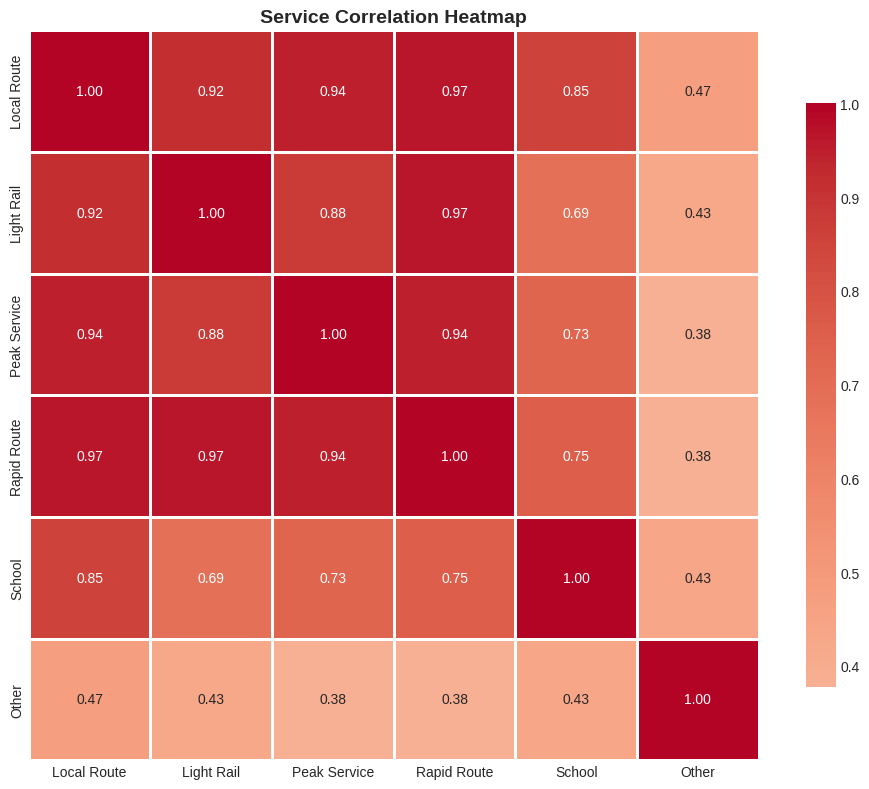


--- WEEKLY PATTERN ANALYSIS ---


<Figure size 1400x600 with 0 Axes>

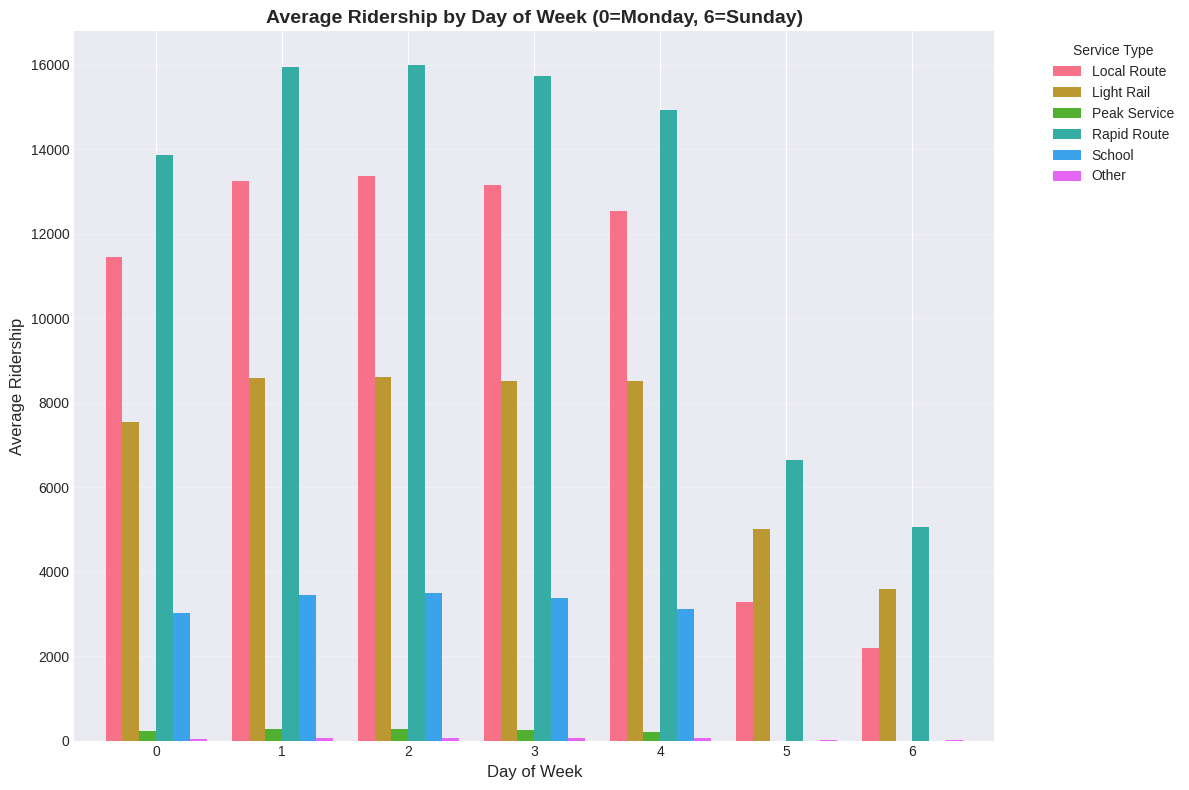


--- MONTHLY SEASONALITY ANALYSIS ---


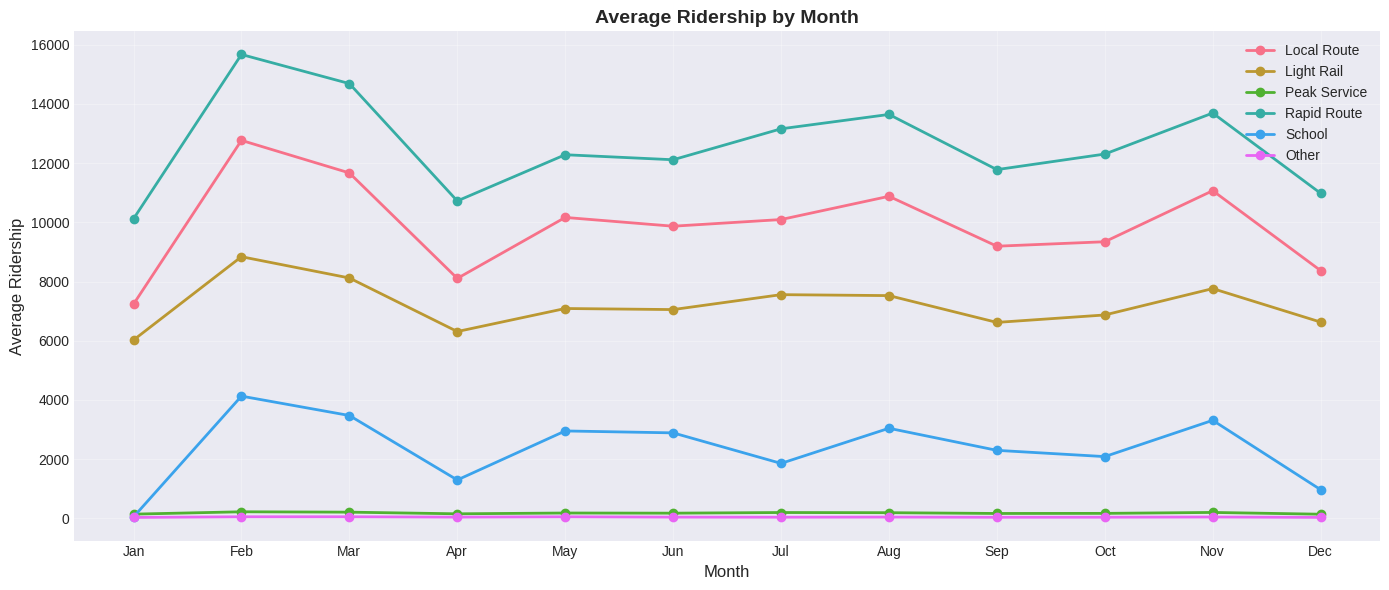


--- DISTRIBUTION ANALYSIS (Boxplot) ---


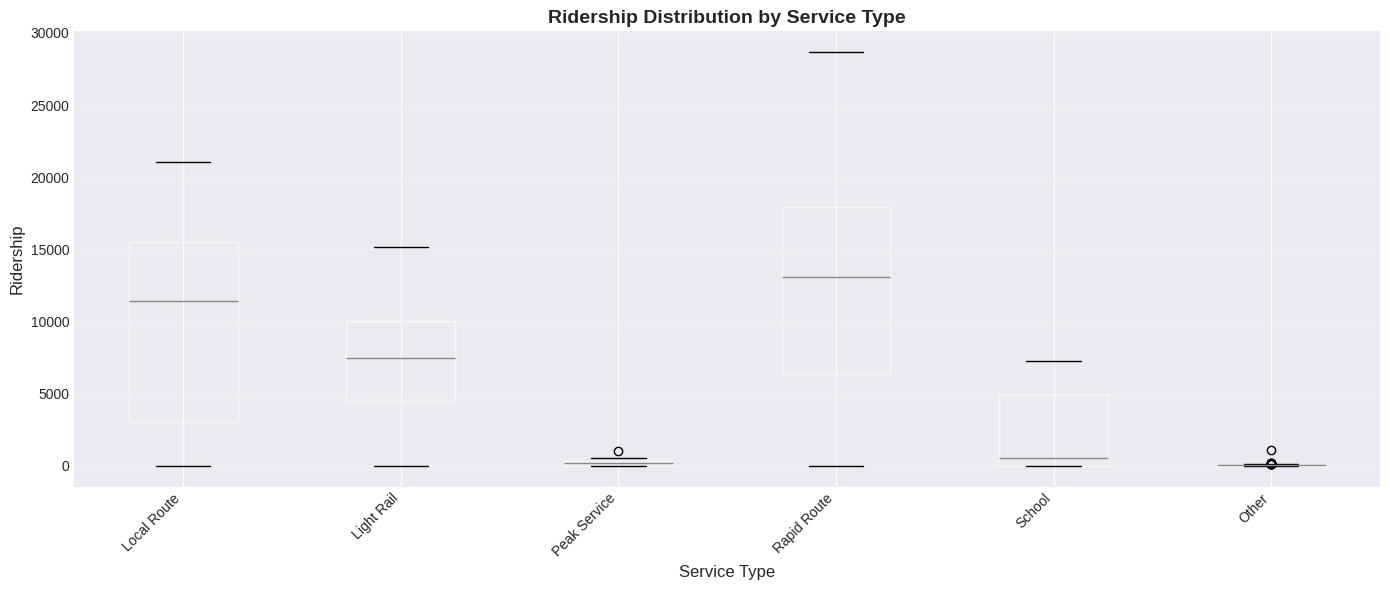


--- WEEKDAY VS WEEKEND COMPARISON ---
                   Weekday      Weekend    Difference    Change %
Local Route   12755.348175  2731.512774  10023.835401   78.585353
Light Rail     8355.815328  4294.523723   4061.291606   48.604372
Peak Service    251.413869     0.000000    251.413869  100.000000
Rapid Route   15297.278102  5847.051095   9450.227007   61.777180
School         3293.729197     0.109489   3293.619708   99.996676
Other            52.808029    18.288321     34.519708   65.368294


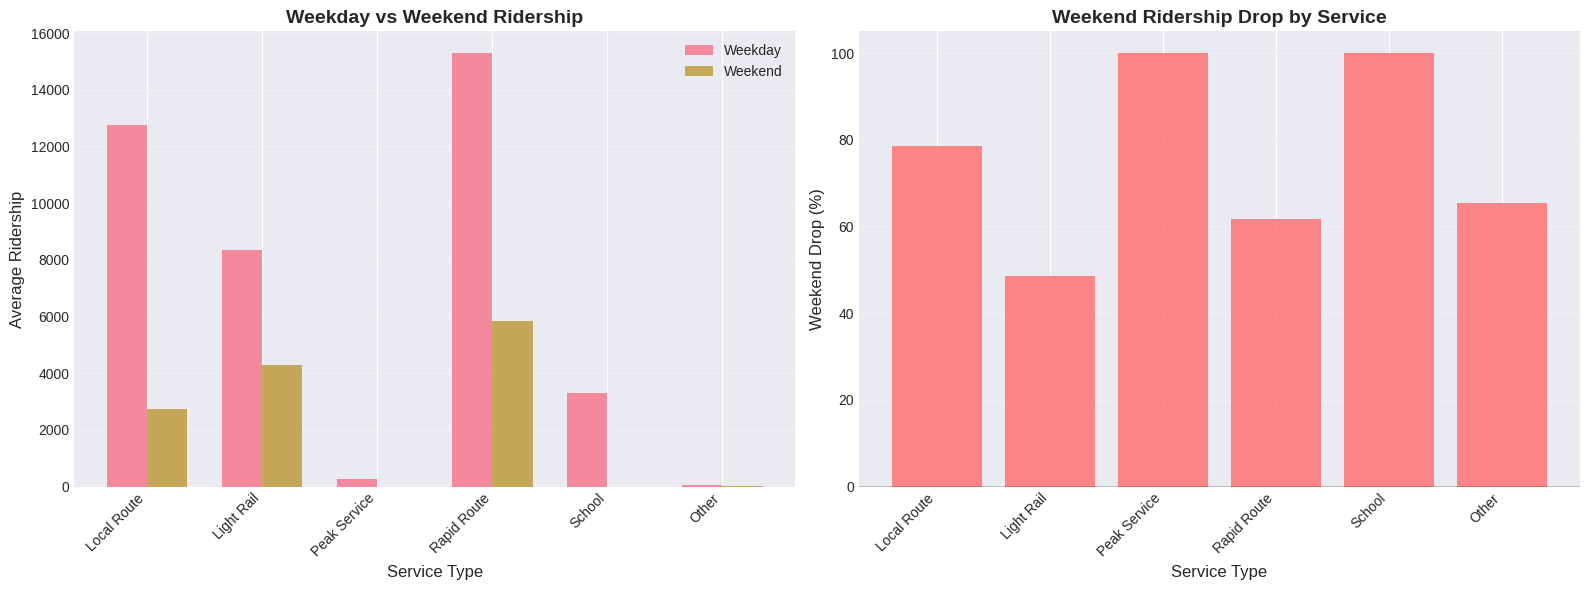

1. RIDERSHIP HIERARCHY:
   • Top Service: Rapid Route - 12,597 riders/day (39.0% of total)
   • 2nd Place: Local Route - 9,891 riders/day (30.7% of total)
   • Total Daily Average: 32,259 riders across all services

2. WEEKEND EFFECT:
   • Average weekend drop: 75.7% across all services
   • Most affected: Peak Service (100.0% drop)
   • Least affected: Light Rail (48.6% drop)

3. SERVICE STABILITY (Coefficient of Variation):
   • Most volatile: School (CV=106.0%) - High day-to-day variation
   • Most stable: Light Rail (CV=46.5%) - Consistent ridership

4. SERVICE RELATIONSHIPS:
   • Strongest correlation: Light Rail ↔ Rapid Route (r=0.968)
     → These services likely share similar usage patterns
   • Weakest correlation: Peak Service ↔ Other (r=0.377)
     → These services serve different rider demographics

5. LONG-TERM TREND:
   • Ridership has GROWN by 6.2% from first to last year

6. PEAK USAGE PATTERNS:
   • Busiest day: Wednesday (41,836 riders)
   • Quietest day: Sunday (10,8

In [105]:
def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""


    ridership_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']

    # Basic Info
    print("\n--- BASIC INFO ---")
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
    print(f"Total Days: {len(df)}")
    print(f"Total Records: {df.shape[0]}")

    print("\n--- MISSING VALUES ---")
    missing = df[ridership_cols].isnull().sum()
    print(missing)
    if missing.sum() == 0:
        print(" No missing values detected!")

    # Summary Statistics
    print("\n--- SUMMARY STATISTICS ---")
    print(df[ridership_cols].describe())


    # 1. COMBINED TIME SERIES PLOT

    print("\n--- Plotting Combined Time Series ---")
    plt.figure(figsize=(16, 7))
    for col in ridership_cols:
        plt.plot(df['Date'], df[col], label=col, linewidth=1.2, alpha=0.8)

    plt.title("Ridership Over Time - All Services", fontsize=16, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Ridership Count", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    # 2. INDIVIDUAL SERVICE PLOTS

    print("\n--- Plotting Individual Service Trends ---")
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle('Individual Service Ridership Trends', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for i, col in enumerate(ridership_cols):
        axes[i].plot(df['Date'], df[col], linewidth=1.2, color=f'C{i}', alpha=0.8)
        axes[i].axhline(y=df[col].mean(), color='red', linestyle='--',
                       linewidth=1.5, label=f'Mean: {df[col].mean():,.0f}', alpha=0.7)
        axes[i].set_title(col, fontsize=12, fontweight='bold')
        axes[i].set_xlabel("Date", fontsize=10)
        axes[i].set_ylabel("Ridership", fontsize=10)
        axes[i].legend(loc='upper right', fontsize=9)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    # 3. CORRELATION HEATMAP

    print("\n--- CORRELATION ANALYSIS ---")
    corr = df[ridership_cols].corr()
    print("Correlation Matrix:")
    print(corr)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f",
                linewidths=1, center=0, square=True,
                cbar_kws={"shrink": 0.8})
    plt.title("Service Correlation Heatmap", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


    # 4. WEEKLY PATTERN ANALYSIS

    print("\n--- WEEKLY PATTERN ANALYSIS ---")
    weekly_avg = df.groupby('DayOfWeek')[ridership_cols].mean()

    plt.figure(figsize=(14, 6))
    weekly_avg.plot(kind='bar', width=0.8)
    plt.title("Average Ridership by Day of Week (0=Monday, 6=Sunday)",
             fontsize=14, fontweight='bold')
    plt.xlabel("Day of Week", fontsize=12)
    plt.ylabel("Average Ridership", fontsize=12)
    plt.legend(title='Service Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


    # 5. MONTHLY SEASONALITY

    print("\n--- MONTHLY SEASONALITY ANALYSIS ---")
    monthly_avg = df.groupby('Month')[ridership_cols].mean()

    plt.figure(figsize=(14, 6))
    for col in ridership_cols:
        plt.plot(monthly_avg.index, monthly_avg[col], marker='o',
                linewidth=2, markersize=6, label=col)

    plt.title("Average Ridership by Month", fontsize=14, fontweight='bold')
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Average Ridership", fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    # 6. BOXPLOT ANALYSIS (Distribution)

    print("\n--- DISTRIBUTION ANALYSIS (Boxplot) ---")
    plt.figure(figsize=(14, 6))
    df[ridership_cols].boxplot(figsize=(14, 6))
    plt.title("Ridership Distribution by Service Type", fontsize=14, fontweight='bold')
    plt.ylabel("Ridership", fontsize=12)
    plt.xlabel("Service Type", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


    # 7. WEEKDAY VS WEEKEND COMPARISON

    print("\n--- WEEKDAY VS WEEKEND COMPARISON ---")
    weekday_avg = df[df['IsWeekend']==0][ridership_cols].mean()
    weekend_avg = df[df['IsWeekend']==1][ridership_cols].mean()

    comparison_df = pd.DataFrame({
        'Weekday': weekday_avg,
        'Weekend': weekend_avg,
        'Difference': weekday_avg - weekend_avg,
        'Change %': ((weekday_avg - weekend_avg) / weekday_avg * 100)
    })
    print(comparison_df)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar comparison
    x = np.arange(len(ridership_cols))
    width = 0.35
    ax1.bar(x - width/2, weekday_avg, width, label='Weekday', alpha=0.8)
    ax1.bar(x + width/2, weekend_avg, width, label='Weekend', alpha=0.8)
    ax1.set_xlabel('Service Type', fontsize=12)
    ax1.set_ylabel('Average Ridership', fontsize=12)
    ax1.set_title('Weekday vs Weekend Ridership', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(ridership_cols, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # Percentage drop
    percent_drop = ((weekday_avg - weekend_avg) / weekday_avg * 100)
    colors = ['#FF6B6B' if x > 0 else '#4ECDC4' for x in percent_drop]
    ax2.bar(ridership_cols, percent_drop, color=colors, alpha=0.8)
    ax2.set_xlabel('Service Type', fontsize=12)
    ax2.set_ylabel('Weekend Drop (%)', fontsize=12)
    ax2.set_title('Weekend Ridership Drop by Service', fontsize=14, fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


    # 8. KEY INSIGHTS


    insights = []

    # Insight 1: Service Volume Comparison
    avg_ridership = df[ridership_cols].mean().sort_values(ascending=False)
    total_ridership = avg_ridership.sum()
    insights.append(f"1. RIDERSHIP HIERARCHY:")
    insights.append(f"   • Top Service: {avg_ridership.index[0]} - {avg_ridership.iloc[0]:,.0f} riders/day ({avg_ridership.iloc[0]/total_ridership*100:.1f}% of total)")
    insights.append(f"   • 2nd Place: {avg_ridership.index[1]} - {avg_ridership.iloc[1]:,.0f} riders/day ({avg_ridership.iloc[1]/total_ridership*100:.1f}% of total)")
    insights.append(f"   • Total Daily Average: {total_ridership:,.0f} riders across all services")

    # Insight 2: Weekend Effect
    weekend_drop = ((df[df['IsWeekend']==0][ridership_cols].mean() -
                    df[df['IsWeekend']==1][ridership_cols].mean()) /
                    df[df['IsWeekend']==0][ridership_cols].mean() * 100)
    most_affected = weekend_drop.idxmax()
    least_affected = weekend_drop.idxmin()
    insights.append(f"\n2. WEEKEND EFFECT:")
    insights.append(f"   • Average weekend drop: {weekend_drop.mean():.1f}% across all services")
    insights.append(f"   • Most affected: {most_affected} ({weekend_drop[most_affected]:.1f}% drop)")
    insights.append(f"   • Least affected: {least_affected} ({weekend_drop[least_affected]:.1f}% drop)")

    # Insight 3: Volatility Analysis
    cv = (df[ridership_cols].std() / df[ridership_cols].mean() * 100).sort_values(ascending=False)
    insights.append(f"\n3. SERVICE STABILITY (Coefficient of Variation):")
    insights.append(f"   • Most volatile: {cv.index[0]} (CV={cv.iloc[0]:.1f}%) - High day-to-day variation")
    insights.append(f"   • Most stable: {cv.index[-1]} (CV={cv.iloc[-1]:.1f}%) - Consistent ridership")

    # Insight 4: Correlation Insight
    corr_unstack = corr.unstack()
    corr_pairs = corr_unstack[(corr_unstack < 1.0) & (corr_unstack.index.get_level_values(0) !=
                                                        corr_unstack.index.get_level_values(1))]
    if len(corr_pairs) > 0:
        strongest_corr_idx = corr_pairs.idxmax()
        strongest_corr_val = corr_pairs.max()
        weakest_corr_idx = corr_pairs.idxmin()
        weakest_corr_val = corr_pairs.min()

        insights.append(f"\n4. SERVICE RELATIONSHIPS:")
        insights.append(f"   • Strongest correlation: {strongest_corr_idx[0]} ↔ {strongest_corr_idx[1]} (r={strongest_corr_val:.3f})")
        insights.append(f"     → These services likely share similar usage patterns")
        insights.append(f"   • Weakest correlation: {weakest_corr_idx[0]} ↔ {weakest_corr_idx[1]} (r={weakest_corr_val:.3f})")
        insights.append(f"     → These services serve different rider demographics")

    # Insight 5: Growth Trend (if applicable)
    if len(df) > 365:  # If we have more than a year of data
        first_year_avg = df[df['Date'] < df['Date'].min() + pd.DateOffset(years=1)]['Total_Ridership'].mean()
        last_year_avg = df[df['Date'] > df['Date'].max() - pd.DateOffset(years=1)]['Total_Ridership'].mean()
        growth = ((last_year_avg - first_year_avg) / first_year_avg) * 100
        insights.append(f"\n5. LONG-TERM TREND:")
        if growth > 0:
            insights.append(f"   • Ridership has GROWN by {growth:.1f}% from first to last year")
        else:
            insights.append(f"   • Ridership has DECLINED by {abs(growth):.1f}% from first to last year")

    # Insight 6: Peak Day and Month
    daily_total = df.groupby('DayOfWeek')['Total_Ridership'].mean()
    monthly_total = df.groupby('Month')['Total_Ridership'].mean()
    peak_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][daily_total.idxmax()]
    low_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][daily_total.idxmin()]
    peak_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][monthly_total.idxmax()-1]
    low_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][monthly_total.idxmin()-1]

    insights.append(f"\n6. PEAK USAGE PATTERNS:")
    insights.append(f"   • Busiest day: {peak_day} ({daily_total.max():,.0f} riders)")
    insights.append(f"   • Quietest day: {low_day} ({daily_total.min():,.0f} riders)")
    insights.append(f"   • Peak month: {peak_month} ({monthly_total.max():,.0f} riders)")
    insights.append(f"   • Lowest month: {low_month} ({monthly_total.min():,.0f} riders)")

    # Print all insights
    for insight in insights:
        print(insight)



    return insights

# Perform EDA
insights = perform_eda(df)

#Step-6: Decompositon


Performing seasonal decomposition (weekly pattern, period=7)...


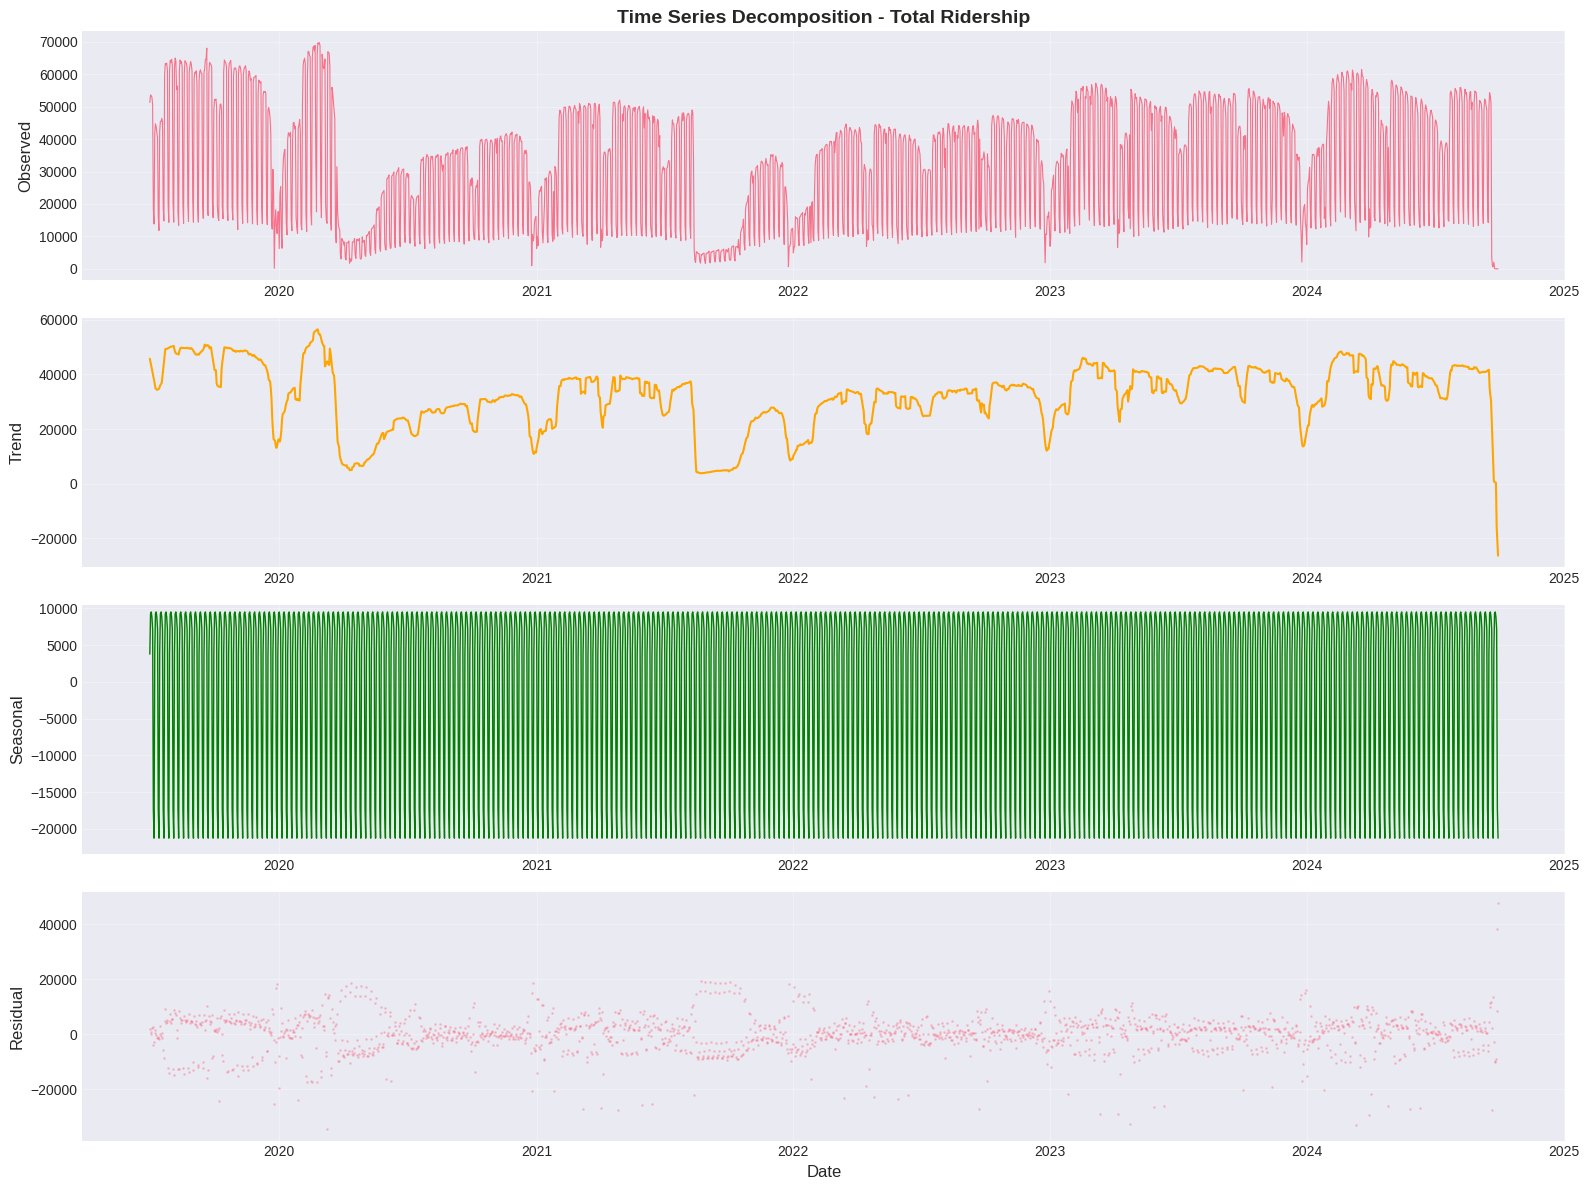


--- ZOOMED VIEW: 8 Weeks of Seasonal Pattern ---


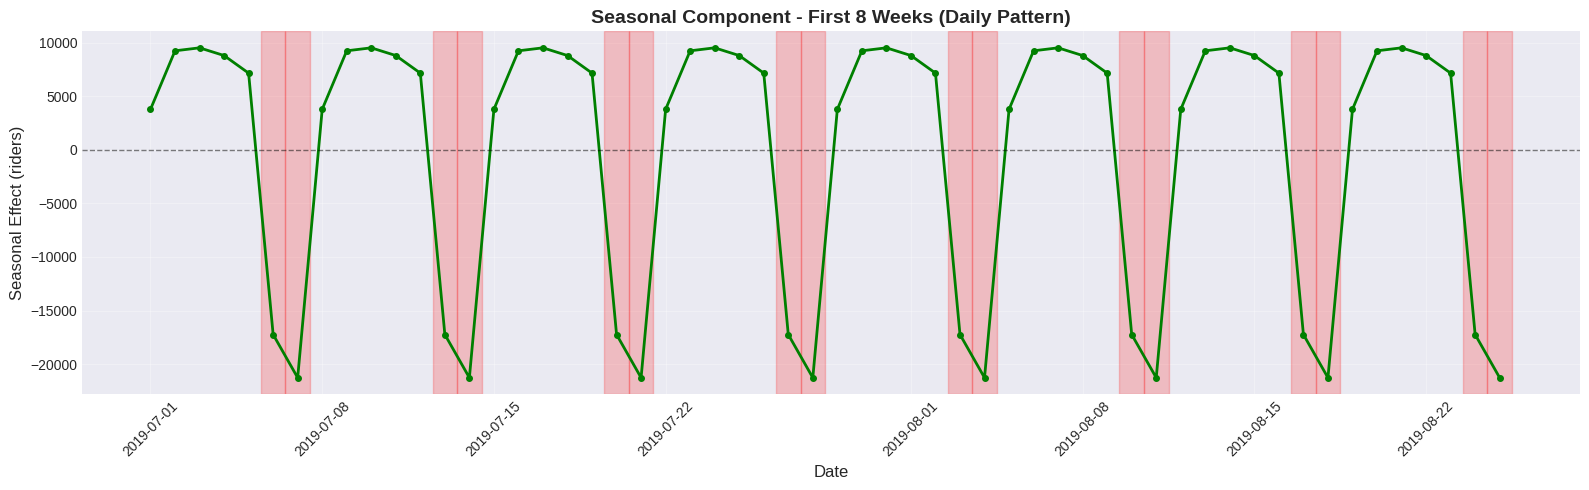


--- SEASONAL PATTERN ANALYSIS ---

Average seasonal effect by day of week:
  Monday    :   +3,780 riders
  Tuesday   :   +9,245 riders
  Wednesday :   +9,523 riders
  Thursday  :   +8,803 riders
  Friday    :   +7,161 riders
  Saturday  :  -17,239 riders
  Sunday    :  -21,272 riders


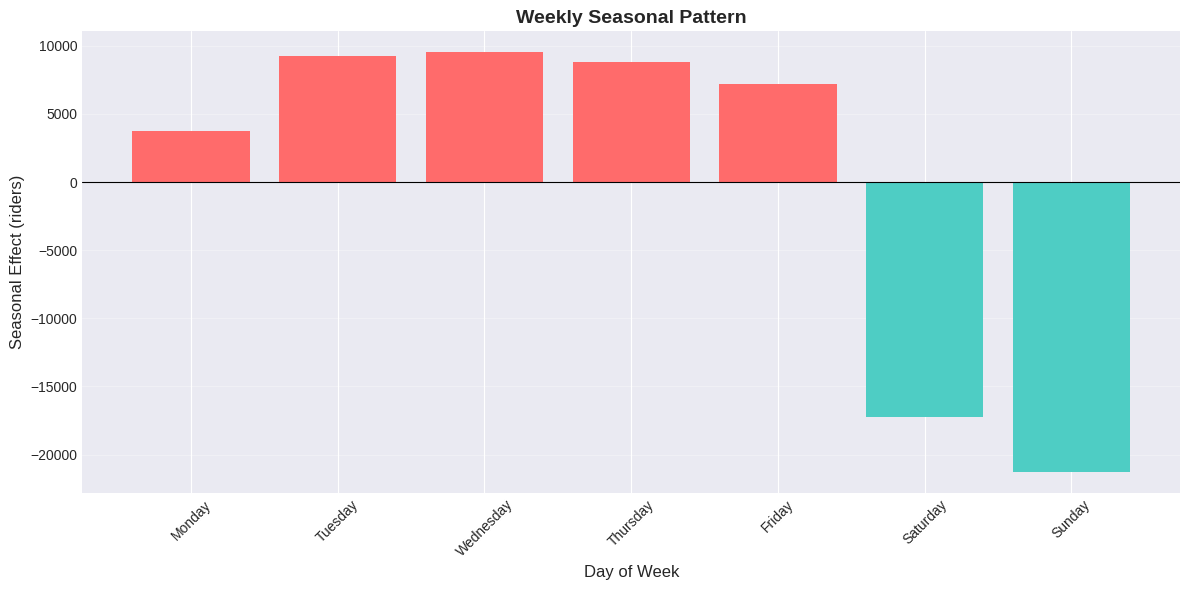


 Decomposition completed!

INTERPRETATION GUIDE

What you're seeing in the SEASONAL component:

The tight, rapid oscillations you see are REAL weekly patterns:
- HIGH peaks = Weekdays (Monday-Friday) - more commuters
- LOW valleys = Weekends (Saturday-Sunday) - fewer riders

This is EXACTLY what we expect for transit data!

The pattern repeats every 7 days, which is why it looks like a dense wave
when viewing years of data. Zoom in to 8 weeks (above) to see it clearly.


    


In [106]:
def decompose_time_series(df):
    """Perform time series decomposition with proper handling"""

    df_continuous = df.set_index('Date')
    date_range = pd.date_range(start=df_continuous.index.min(),
                               end=df_continuous.index.max(),
                               freq='D')
    df_continuous = df_continuous.reindex(date_range)
    df_continuous['Total_Ridership'] = df_continuous['Total_Ridership'].interpolate(method='linear')
    print("\nPerforming seasonal decomposition (weekly pattern, period=7)...")
    decomposition = seasonal_decompose(df_continuous['Total_Ridership'],
                                      model='additive',
                                      period=7,
                                      extrapolate_trend='freq')
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    axes[0].plot(decomposition.observed, linewidth=0.8)
    axes[0].set_ylabel('Observed', fontsize=12)
    axes[0].set_title('Time Series Decomposition - Total Ridership', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)


    axes[1].plot(decomposition.trend, linewidth=1.5, color='orange')
    axes[1].set_ylabel('Trend', fontsize=12)
    axes[1].grid(True, alpha=0.3)


    axes[2].plot(decomposition.seasonal, linewidth=1, color='green')
    axes[2].set_ylabel('Seasonal', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([decomposition.seasonal.min() * 1.1, decomposition.seasonal.max() * 1.1])

    axes[3].scatter(decomposition.resid.index, decomposition.resid, alpha=0.3, s=1)
    axes[3].set_ylabel('Residual', fontsize=12)
    axes[3].set_xlabel('Date', fontsize=12)
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("\n--- ZOOMED VIEW: 8 Weeks of Seasonal Pattern ---")
    fig, ax = plt.subplots(figsize=(16, 5))
    seasonal_zoom = decomposition.seasonal[:56]

    ax.plot(seasonal_zoom.index, seasonal_zoom.values, linewidth=2, color='green', marker='o', markersize=4)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_title('Seasonal Component - First 8 Weeks (Daily Pattern)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Seasonal Effect (riders)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.grid(True, alpha=0.3)
    for i, date in enumerate(seasonal_zoom.index):
        if date.dayofweek >= 5:
            ax.axvspan(date - pd.Timedelta(hours=12), date + pd.Timedelta(hours=12),
                      alpha=0.2, color='red', label='Weekend' if i == 0 else '')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    print("\n--- SEASONAL PATTERN ANALYSIS ---")
    seasonal_values = decomposition.seasonal[:7].values
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print("\nAverage seasonal effect by day of week:")
    for day, value in zip(days, seasonal_values):
        print(f"  {day:10s}: {value:+8,.0f} riders")

    plt.figure(figsize=(12, 6))
    plt.bar(days, seasonal_values, color=['#FF6B6B' if i < 5 else '#4ECDC4' for i in range(7)])
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.title('Weekly Seasonal Pattern', fontsize=14, fontweight='bold')
    plt.ylabel('Seasonal Effect (riders)', fontsize=12)
    plt.xlabel('Day of Week', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    print("\n Decomposition completed!")

    print("\n" + "="*80)
    print("INTERPRETATION GUIDE")
    print("="*80)
    print("""
What you're seeing in the SEASONAL component:

The tight, rapid oscillations you see are REAL weekly patterns:
- HIGH peaks = Weekdays (Monday-Friday) - more commuters
- LOW valleys = Weekends (Saturday-Sunday) - fewer riders

This is EXACTLY what we expect for transit data!

The pattern repeats every 7 days, which is why it looks like a dense wave
when viewing years of data. Zoom in to 8 weeks (above) to see it clearly.


    """)

    return decomposition

decomposition = decompose_time_series(df)

#Step-7: Stationary Testing & Augmented Dickey Fuller Test

In [93]:
def test_stationarity(series, series_name):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    print(f"\n--- ADF Test for {series_name} ---")

    series = series.dropna()

    result = adfuller(series, autolag='AIC')

    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Number of lags used: {result[2]}')
    print(f'Number of observations: {result[3]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print(f" STATIONARY: Reject null hypothesis (p-value={result[1]:.4f})")
        is_stationary = True
    else:
        print(f" NON-STATIONARY: Fail to reject null hypothesis (p-value={result[1]:.4f})")
        print("  → Differencing required")
        is_stationary = False

    return is_stationary, result

def make_stationary(df, columns):
    """Test and transform series to achieve stationarity"""


    stationarity_results = {}

    for col in columns:


        is_stationary, adf_result = test_stationarity(df[col], col)
        stationarity_results[col] = {
            'original_stationary': is_stationary,
            'original_pvalue': adf_result[1]
        }

        if not is_stationary:
            df[f'{col}_diff'] = df[col].diff()
            is_stationary_diff, adf_result_diff = test_stationarity(
                df[f'{col}_diff'].dropna(), f'{col} (First Difference)'
            )
            stationarity_results[col]['diff_stationary'] = is_stationary_diff
            stationarity_results[col]['diff_pvalue'] = adf_result_diff[1]

    return df, stationarity_results

ridership_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

df, stationarity_results = make_stationary(df, ridership_cols)


--- ADF Test for Local Route ---
ADF Statistic: -4.580036
p-value: 0.000141
Number of lags used: 21
Number of observations: 1896
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
 STATIONARY: Reject null hypothesis (p-value=0.0001)

--- ADF Test for Light Rail ---
ADF Statistic: -3.496059
p-value: 0.008089
Number of lags used: 26
Number of observations: 1891
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
 STATIONARY: Reject null hypothesis (p-value=0.0081)

--- ADF Test for Peak Service ---
ADF Statistic: -3.870723
p-value: 0.002261
Number of lags used: 21
Number of observations: 1896
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
 STATIONARY: Reject null hypothesis (p-value=0.0023)

--- ADF Test for Rapid Route ---
ADF Statistic: -3.828102
p-value: 0.002633
Number of lags used: 21
Number of observations: 1896
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
 STATIONARY: Reject null hypothesis (p-value=0.0026)

--- ADF Test for School ---
ADF Statistic: -7.13391

In [ ]:
#So Data Was Already Stationary,  which means Constant mean,variance so we can move to next step

#Step-8: Auto-correlation Factor & Partial Auto-correlation Factor ANALYSIS

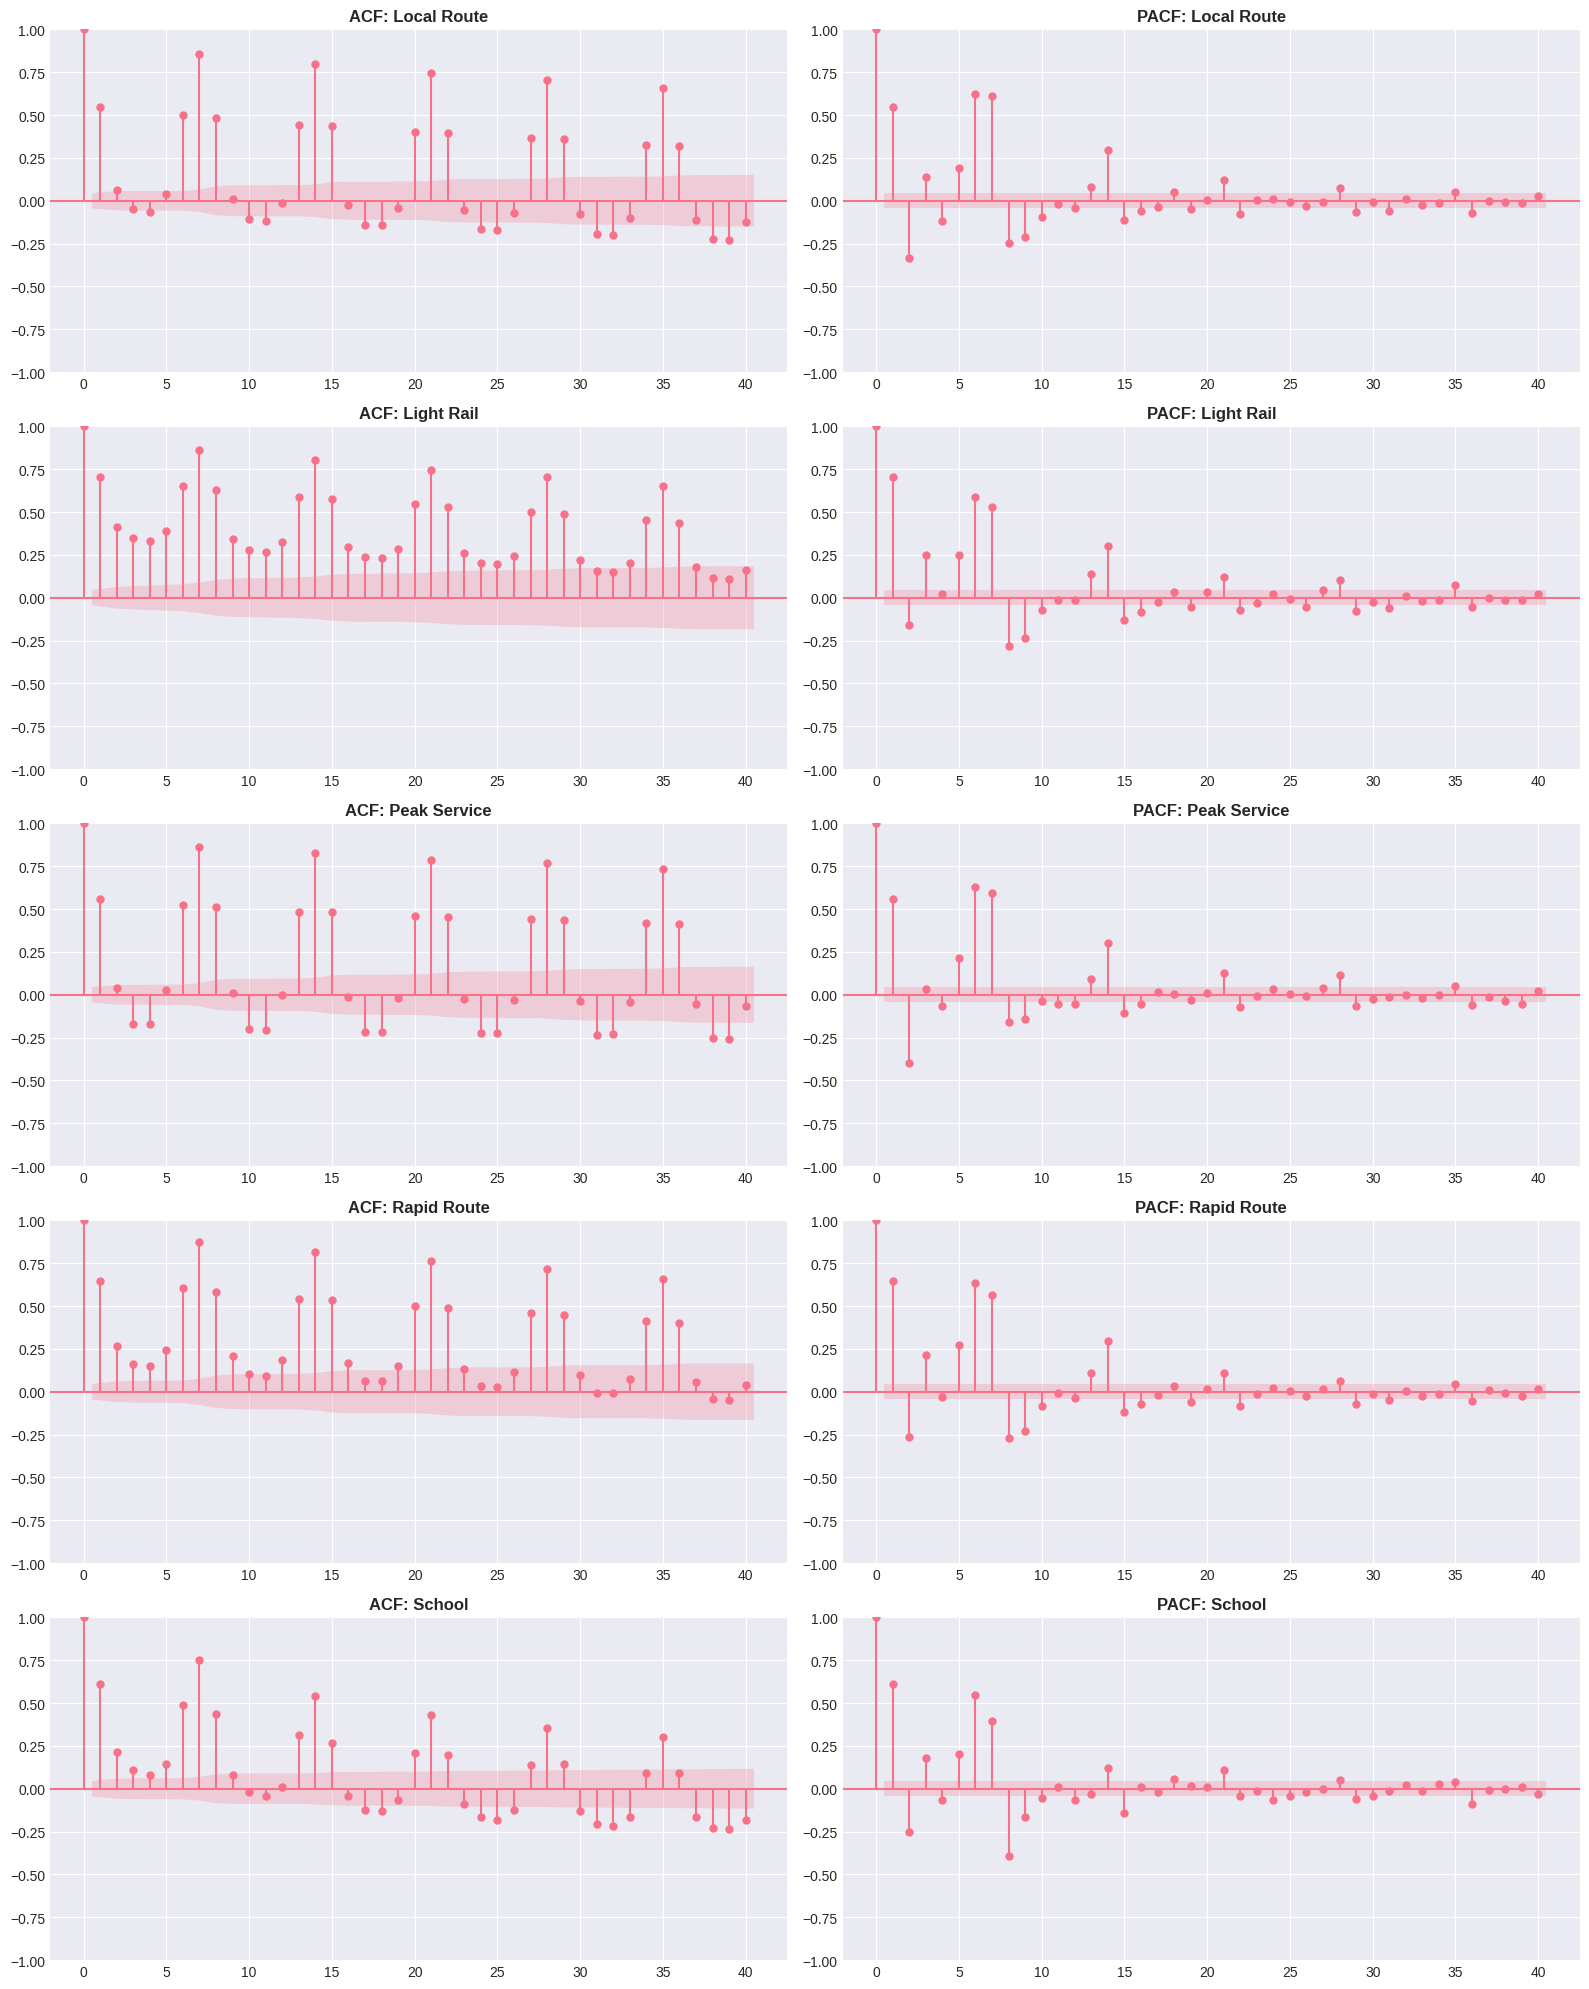


--- SUGGESTED ARIMA PARAMETERS ---
Based on ACF/PACF analysis:
- Look for PACF cutoff for AR(p) order
- Look for ACF cutoff for MA(q) order
- Typical starting point: ARIMA(1,1,1) or SARIMA(1,1,1)(1,1,1,7)


In [94]:
def plot_acf_pacf(df, columns):


    fig, axes = plt.subplots(len(columns), 2, figsize=(16, 4*len(columns)))

    for idx, col in enumerate(columns):
        series = df[col].dropna()

        # ACF
        plot_acf(series, lags=40, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'ACF: {col}', fontsize=12, fontweight='bold')

        # PACF
        plot_pacf(series, lags=40, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'PACF: {col}', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n--- SUGGESTED ARIMA PARAMETERS ---")
    print("Based on ACF/PACF analysis:")
    print("- Look for PACF cutoff for AR(p) order")
    print("- Look for ACF cutoff for MA(q) order")
    print("- Typical starting point: ARIMA(1,1,1) or SARIMA(1,1,1)(1,1,1,7)")

plot_acf_pacf(df, ridership_cols)


#Step-9: Model Utility Functions

In [95]:
def split_train_test(df, column, test_days=30):
    """Split data into train and test sets"""
    train = df[column][:-test_days]
    test = df[column][-test_days:]
    return train, test

def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:,.2f}")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

print("✓ Utility functions defined!")

✓ Utility functions defined!


#Step-10: Build ARIMA Model(Auto-regression Integrated Moving Average)


--- Building ARIMA(1, 1, 1) Model ---

ARIMA(1, 1, 1) Performance:
  MAE:  8,479.38
  RMSE: 10,620.86
  MAPE: inf%
  R²:   -0.5516


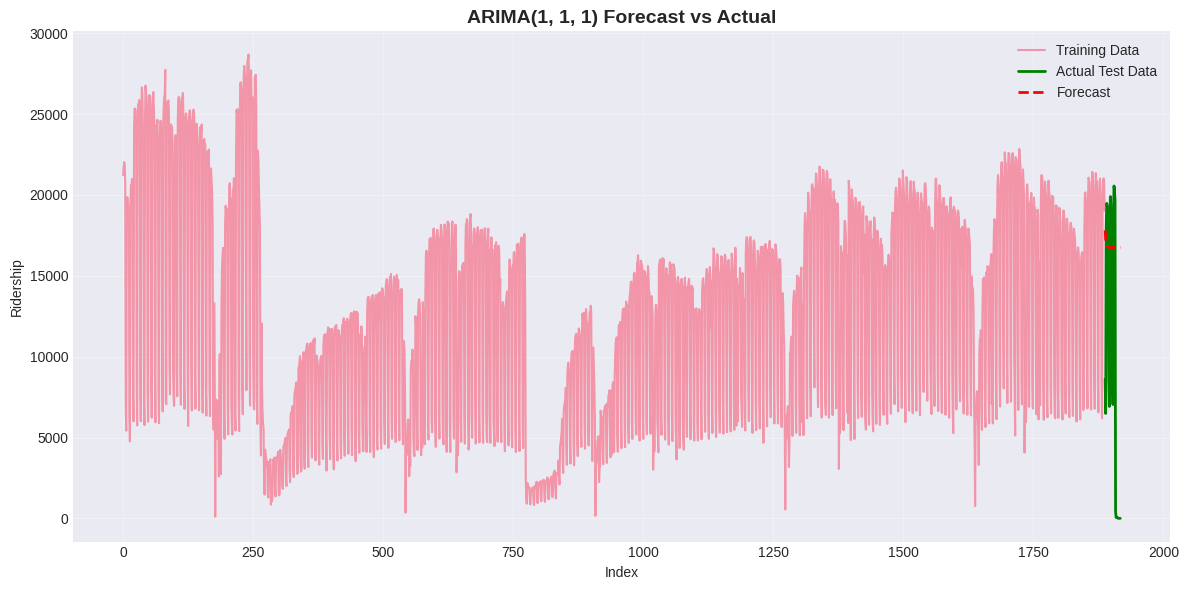

In [96]:
def build_arima_model(train, test, order=(1,1,1)):
    """Build and evaluate ARIMA model"""
    print(f"\n--- Building ARIMA{order} Model ---")

    model = ARIMA(train, order=order)
    fitted_model = model.fit()

    forecast = fitted_model.forecast(steps=len(test))
    metrics = evaluate_model(test, forecast, f"ARIMA{order}")
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', alpha=0.7)
    plt.plot(test.index, test, label='Actual Test Data', color='green', linewidth=2)
    plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title(f'ARIMA{order} Forecast vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Ridership')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return fitted_model, forecast, metrics


test_column = 'Rapid Route'
train, test = split_train_test(df, test_column, test_days=30)

arima_model, arima_forecast, arima_metrics = build_arima_model(train, test, order=(1,1,1))

##Hyper-parameter Tuning for ARIMA

In [97]:
def tune_arima_parameters(train, test, p_range=range(0,3), d_range=range(0,2), q_range=range(0,3)):
    """Grid search for best ARIMA parameters"""


    best_aic = np.inf
    best_order = None
    best_model = None

    results = []

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train, order=(p,d,q))
                    fitted = model.fit()

                    # Forecast and evaluate
                    forecast = fitted.forecast(steps=len(test))
                    mae = mean_absolute_error(test, forecast)

                    results.append({
                        'order': (p,d,q),
                        'AIC': fitted.aic,
                        'BIC': fitted.bic,
                        'MAE': mae
                    })

                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p,d,q)
                        best_model = fitted

                    print(f"ARIMA{(p,d,q)}: AIC={fitted.aic:.2f}, MAE={mae:.2f}")

                except:
                    continue

    print(f"\n Best ARIMA order: {best_order} (AIC={best_aic:.2f})")

    # Visualize tuning results
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(results_df['AIC'], results_df['MAE'], alpha=0.6)
    plt.xlabel('AIC')
    plt.ylabel('MAE')
    plt.title('AIC vs MAE')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    top_models = results_df.nsmallest(5, 'AIC')
    plt.barh(range(len(top_models)), top_models['AIC'])
    plt.yticks(range(len(top_models)), [str(o) for o in top_models['order']])
    plt.xlabel('AIC')
    plt.title('Top 5 Models by AIC')
    plt.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    return best_model, best_order, results_df

##Tuning ARIMA Parameters

ARIMA(0, 0, 0): AIC=50971.78, MAE=8166.74
ARIMA(0, 0, 1): AIC=37522.35, MAE=8256.92
ARIMA(0, 0, 2): AIC=37389.47, MAE=8269.63
ARIMA(0, 1, 0): AIC=37945.94, MAE=8890.70
ARIMA(0, 1, 1): AIC=37933.83, MAE=8766.43
ARIMA(0, 1, 2): AIC=37141.20, MAE=8482.86
ARIMA(1, 0, 0): AIC=37602.41, MAE=8253.62
ARIMA(1, 0, 1): AIC=37380.90, MAE=8298.06
ARIMA(1, 0, 2): AIC=37163.85, MAE=8312.76
ARIMA(1, 1, 0): AIC=37944.56, MAE=8852.89
ARIMA(1, 1, 1): AIC=37452.46, MAE=8479.38
ARIMA(1, 1, 2): AIC=37139.45, MAE=8480.35
ARIMA(2, 0, 0): AIC=37464.61, MAE=8323.64
ARIMA(2, 0, 1): AIC=37382.52, MAE=8297.78
ARIMA(2, 0, 2): AIC=37159.77, MAE=8316.72
ARIMA(2, 1, 0): AIC=37617.49, MAE=9180.87
ARIMA(2, 1, 1): AIC=37098.41, MAE=8400.70
ARIMA(2, 1, 2): AIC=36639.93, MAE=8163.74

 Best ARIMA order: (2, 1, 2) (AIC=36639.93)


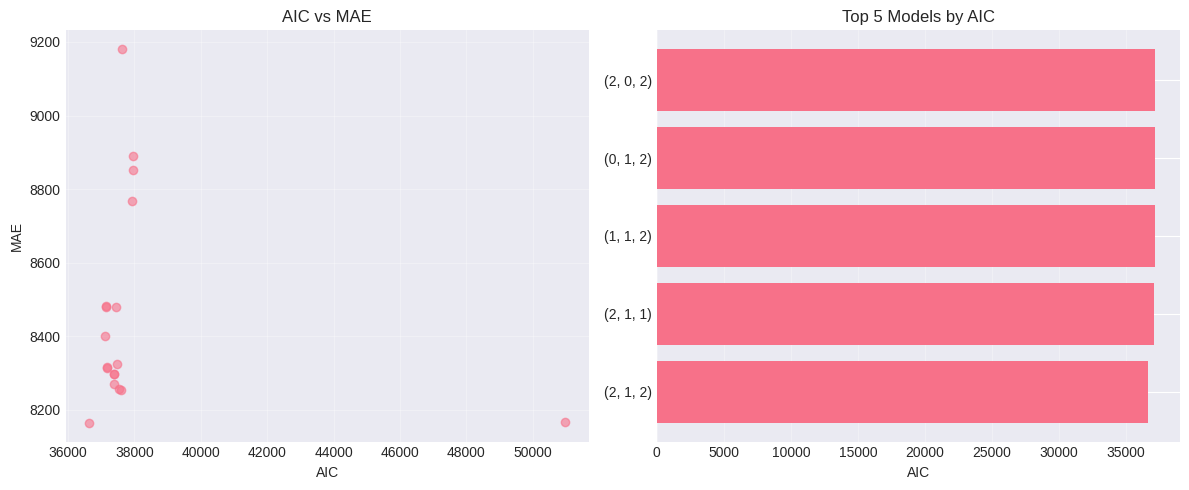

In [98]:
# Tune ARIMA parameters
best_arima_tuned, best_order, tuning_results = tune_arima_parameters(
    train, test, p_range=range(0,3), d_range=range(0,2), q_range=range(0,3)
)

#Step-11: Build SARIMA Model(Seasonal-ARIMA)


--- Building SARIMA(1, 1, 1)x(1, 1, 1, 7) Model ---

SARIMA(1, 1, 1)x(1, 1, 1, 7) Performance:
  MAE:  5,958.24
  RMSE: 9,683.73
  MAPE: inf%
  R²:   -0.2899


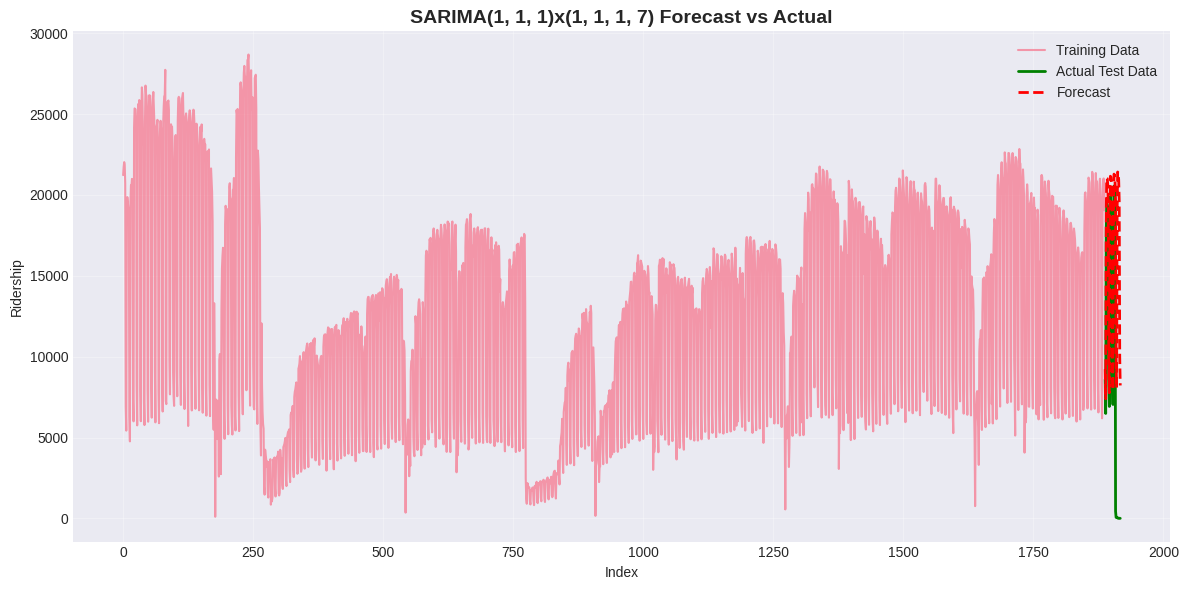

In [99]:
def build_sarima_model(train, test, order=(1,1,1), seasonal_order=(1,1,1,7)):
    """Build and evaluate SARIMA model"""
    print(f"\n--- Building SARIMA{order}x{seasonal_order} Model ---")

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit(disp=False)

    # Forecast
    forecast = fitted_model.forecast(steps=len(test))

    # Evaluate
    metrics = evaluate_model(test, forecast, f"SARIMA{order}x{seasonal_order}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data', alpha=0.7)
    plt.plot(test.index, test, label='Actual Test Data', color='green', linewidth=2)
    plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title(f'SARIMA{order}x{seasonal_order} Forecast vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Ridership')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return fitted_model, forecast, metrics

# Test SARIMA
sarima_model, sarima_forecast, sarima_metrics = build_sarima_model(
    train, test, order=(1,1,1), seasonal_order=(1,1,1,7)
)

#step-12: Build Prophet Model


--- Building Prophet Model ---

Prophet Performance:
  MAE:  5,193.76
  RMSE: 8,218.97
  MAPE: inf%
  R²:   0.0708


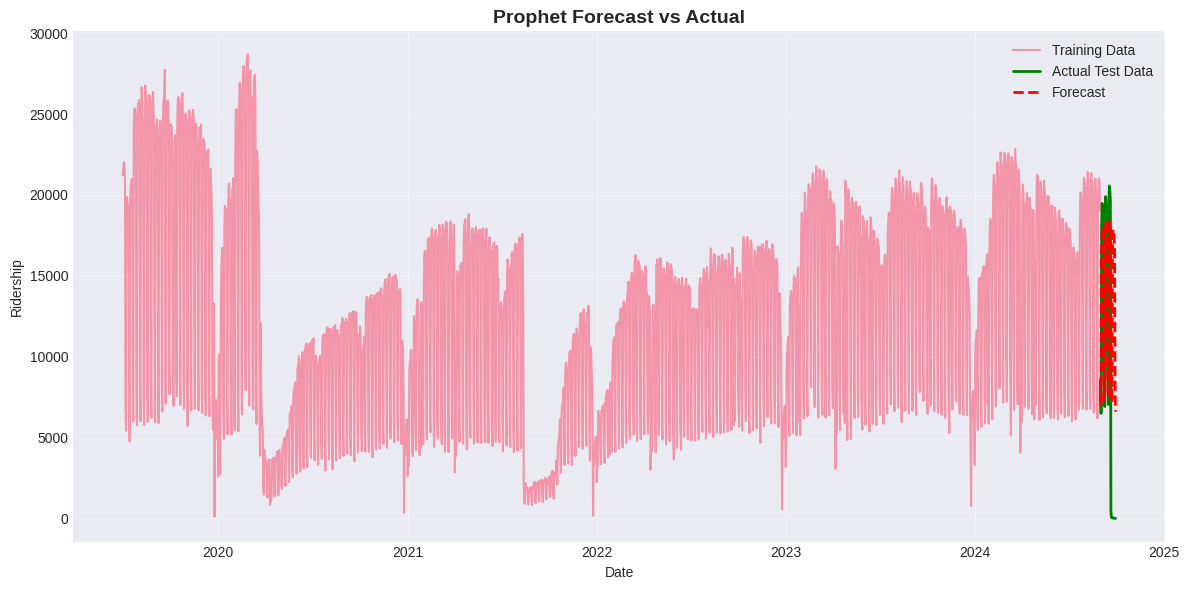

In [100]:
def build_prophet_model(df, column, test_days=30):
    """Build and evaluate Prophet model"""
    print(f"\n--- Building Prophet Model ---")

    # Prepare data for Prophet
    prophet_df = pd.DataFrame({
        'ds': df['Date'],
        'y': df[column]
    })

    train = prophet_df[:-test_days]
    test = prophet_df[-test_days:]

    # Build model
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    model.fit(train)

    # Forecast
    future = model.make_future_dataframe(periods=test_days)
    forecast = model.predict(future)

    # Extract predictions for test period
    predictions = forecast['yhat'][-test_days:].values

    # Evaluate
    metrics = evaluate_model(test['y'], predictions, "Prophet")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train['ds'], train['y'], label='Training Data', alpha=0.7)
    plt.plot(test['ds'], test['y'], label='Actual Test Data', color='green', linewidth=2)
    plt.plot(test['ds'], predictions, label='Forecast', color='red', linestyle='--', linewidth=2)
    plt.title('Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Ridership')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return model, forecast, metrics

# Test Prophet
prophet_model, prophet_forecast, prophet_metrics = build_prophet_model(df, test_column, test_days=30)

#Step-14: Compare All Models


ARIMA(2, 1, 2) (Tuned) Performance:
  MAE:  8,163.74
  RMSE: 11,215.25
  MAPE: inf%
  R²:   -0.7302

--- MODEL PERFORMANCE COMPARISON ---
                                 MAE          RMSE  MAPE        R2
Prophet                  5193.762497   8218.970240   inf  0.070815
SARIMA(1,1,1)x(1,1,1,7)  5958.241670   9683.733127   inf -0.289891
ARIMA(1,1,1)             8479.382747  10620.856651   inf -0.551623
ARIMA(2, 1, 2) (Tuned)   8163.735842  11215.252964   inf -0.730156


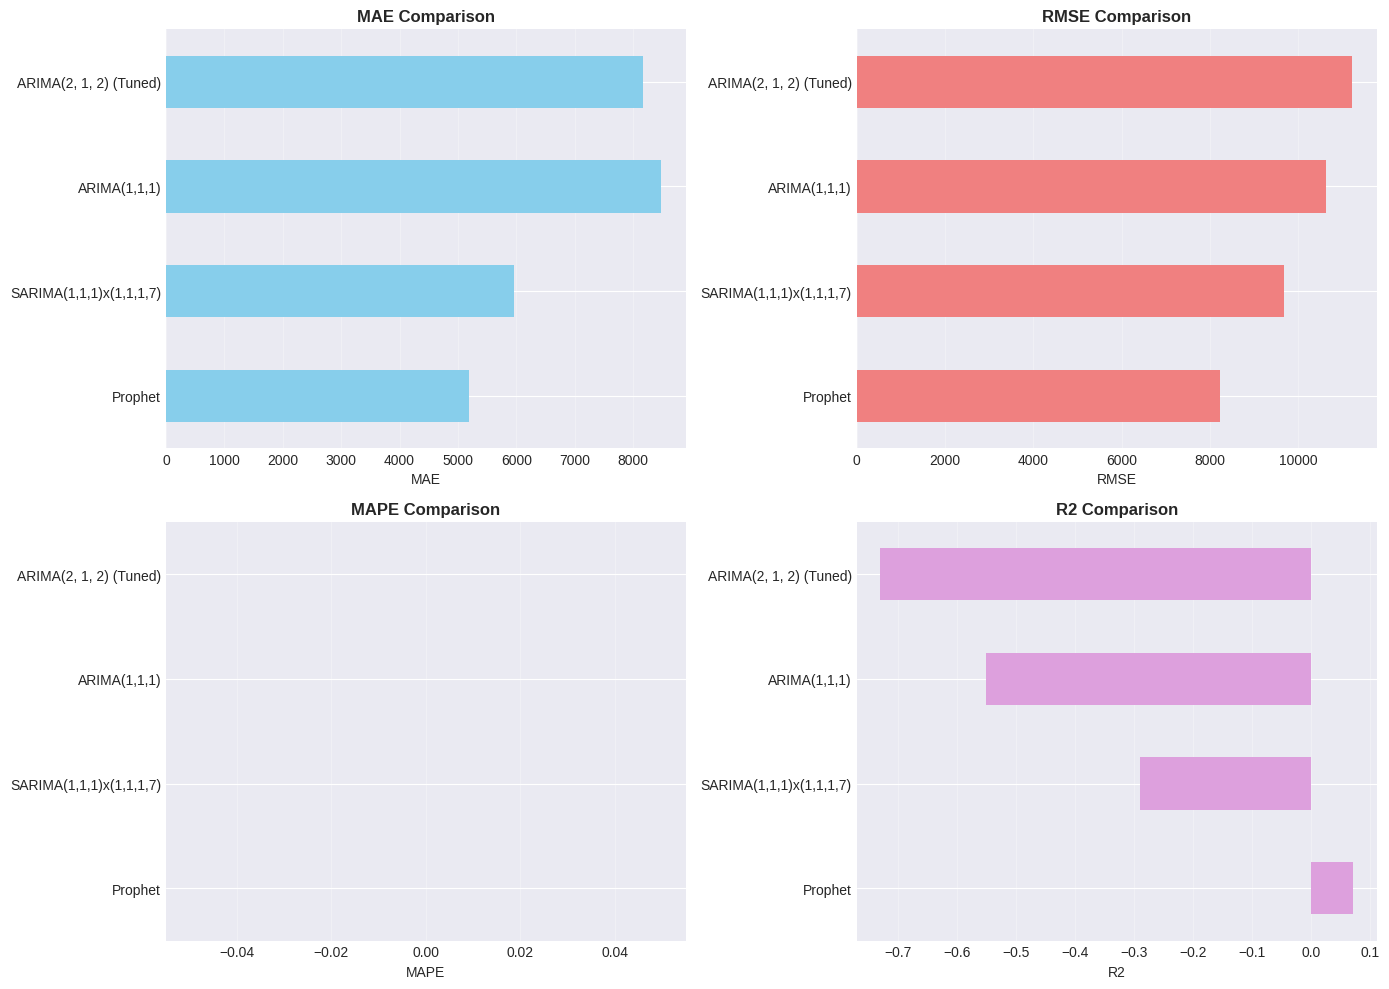

MAE     5193.762497
RMSE    8218.970240
MAPE            inf
R2         0.070815
Name: Prophet, dtype: float64


In [102]:
def compare_models(results_dict):
    """Compare all models and visualize results"""


    # Create comparison DataFrame
    comparison_df = pd.DataFrame(results_dict).T
    comparison_df = comparison_df.sort_values('RMSE')

    print("\n--- MODEL PERFORMANCE COMPARISON ---")
    print(comparison_df.to_string())

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    metrics = ['MAE', 'RMSE', 'MAPE', 'R2']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        comparison_df[metric].plot(kind='barh', ax=ax, color=colors[idx])
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.set_xlabel(metric)
        ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Determine best model
    best_model = comparison_df['RMSE'].idxmin()

    print(comparison_df.loc[best_model])

    return comparison_df, best_model

# Collect all model results
forecast_tuned = best_arima_tuned.forecast(steps=len(test))
metrics_tuned = evaluate_model(test, forecast_tuned, f"ARIMA{best_order} (Tuned)")

results_dict = {
    'ARIMA(1,1,1)': arima_metrics,
    'SARIMA(1,1,1)x(1,1,1,7)': sarima_metrics,
    'Prophet': prophet_metrics,
    f'ARIMA{best_order} (Tuned)': metrics_tuned
}

# Compare models
comparison_df, best_model_name = compare_models(results_dict)

#Step-15: 7-day Forecasting for all services

##Generate-7 day Forecasts using prophet because it performed well

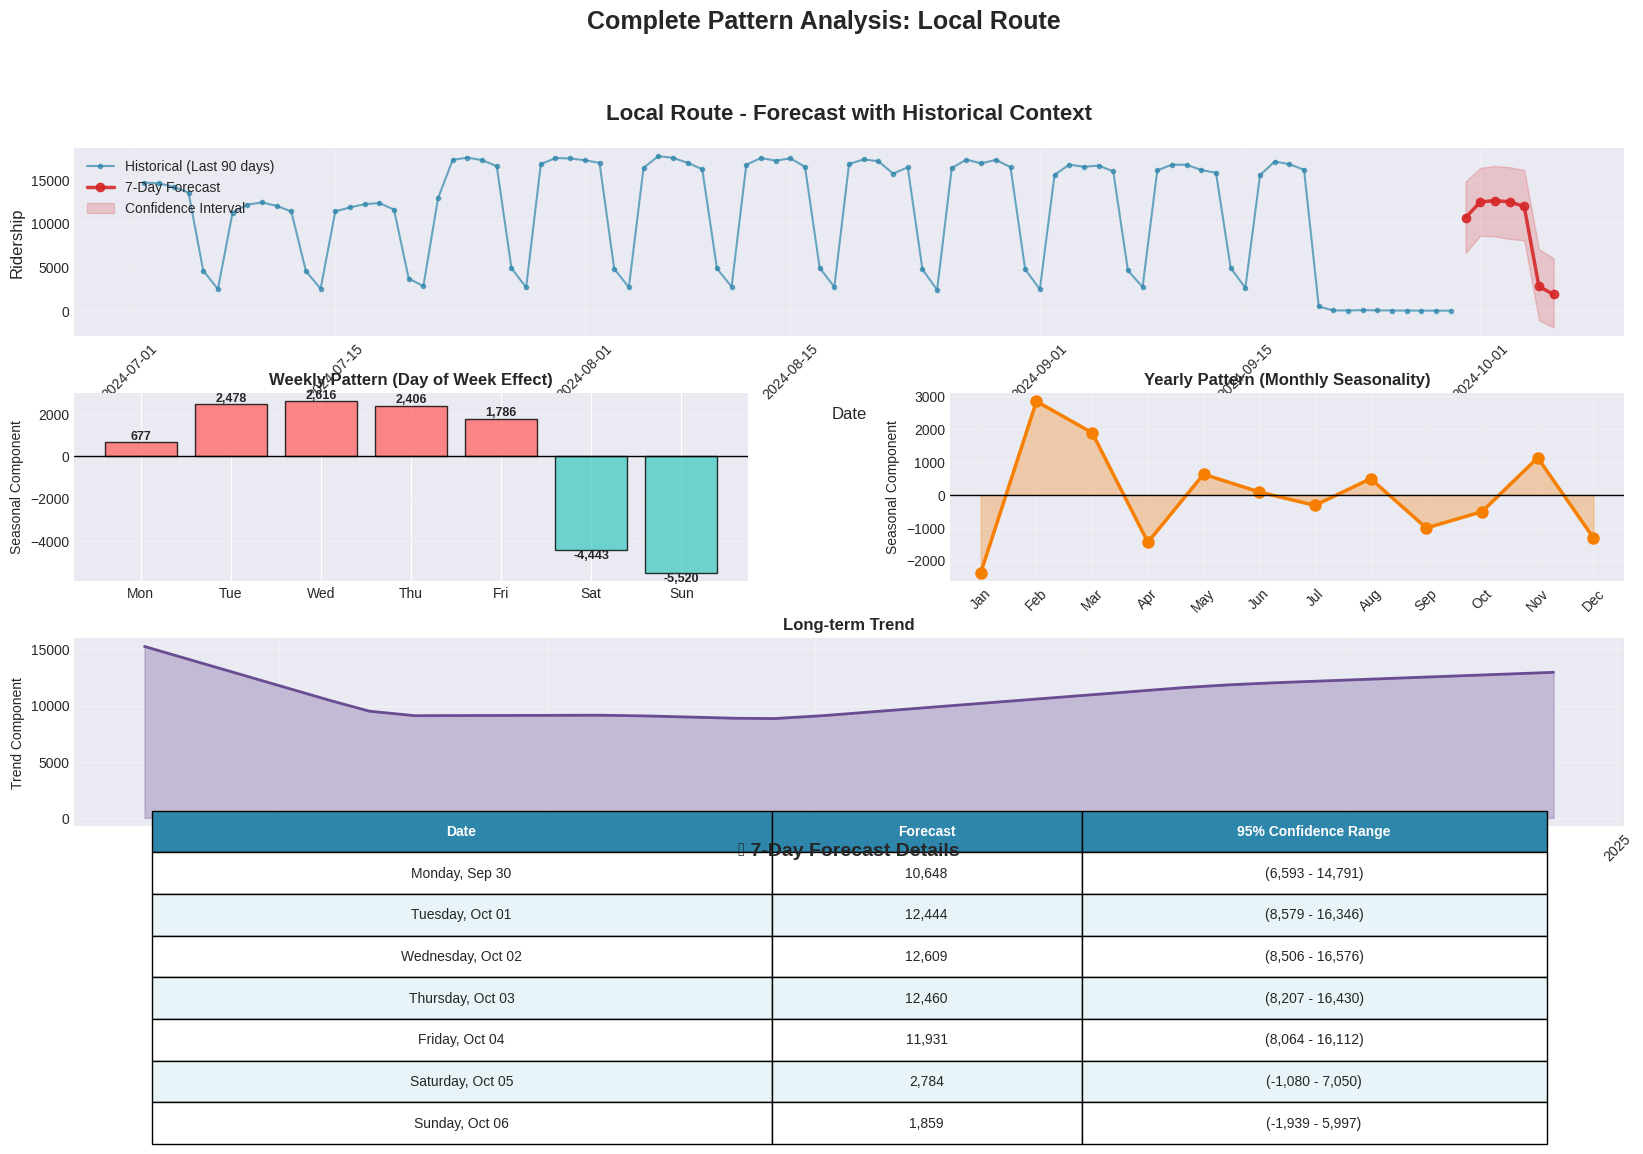


📊 Weekly Pattern:
  Highest ridership: Wed (+2,616)
  Lowest ridership:  Sun (-5,520)
  Weekend drop:      -4,981 (avg Sat-Sun)

📅 Monthly Pattern:
  Peak month:   Jan (+2,846)
  Lowest month: Dec (-2,373)

🔮 Next 7 Days:
  Average forecast: 9,248 riders/day
  Total forecast:   64,735 riders (7 days)


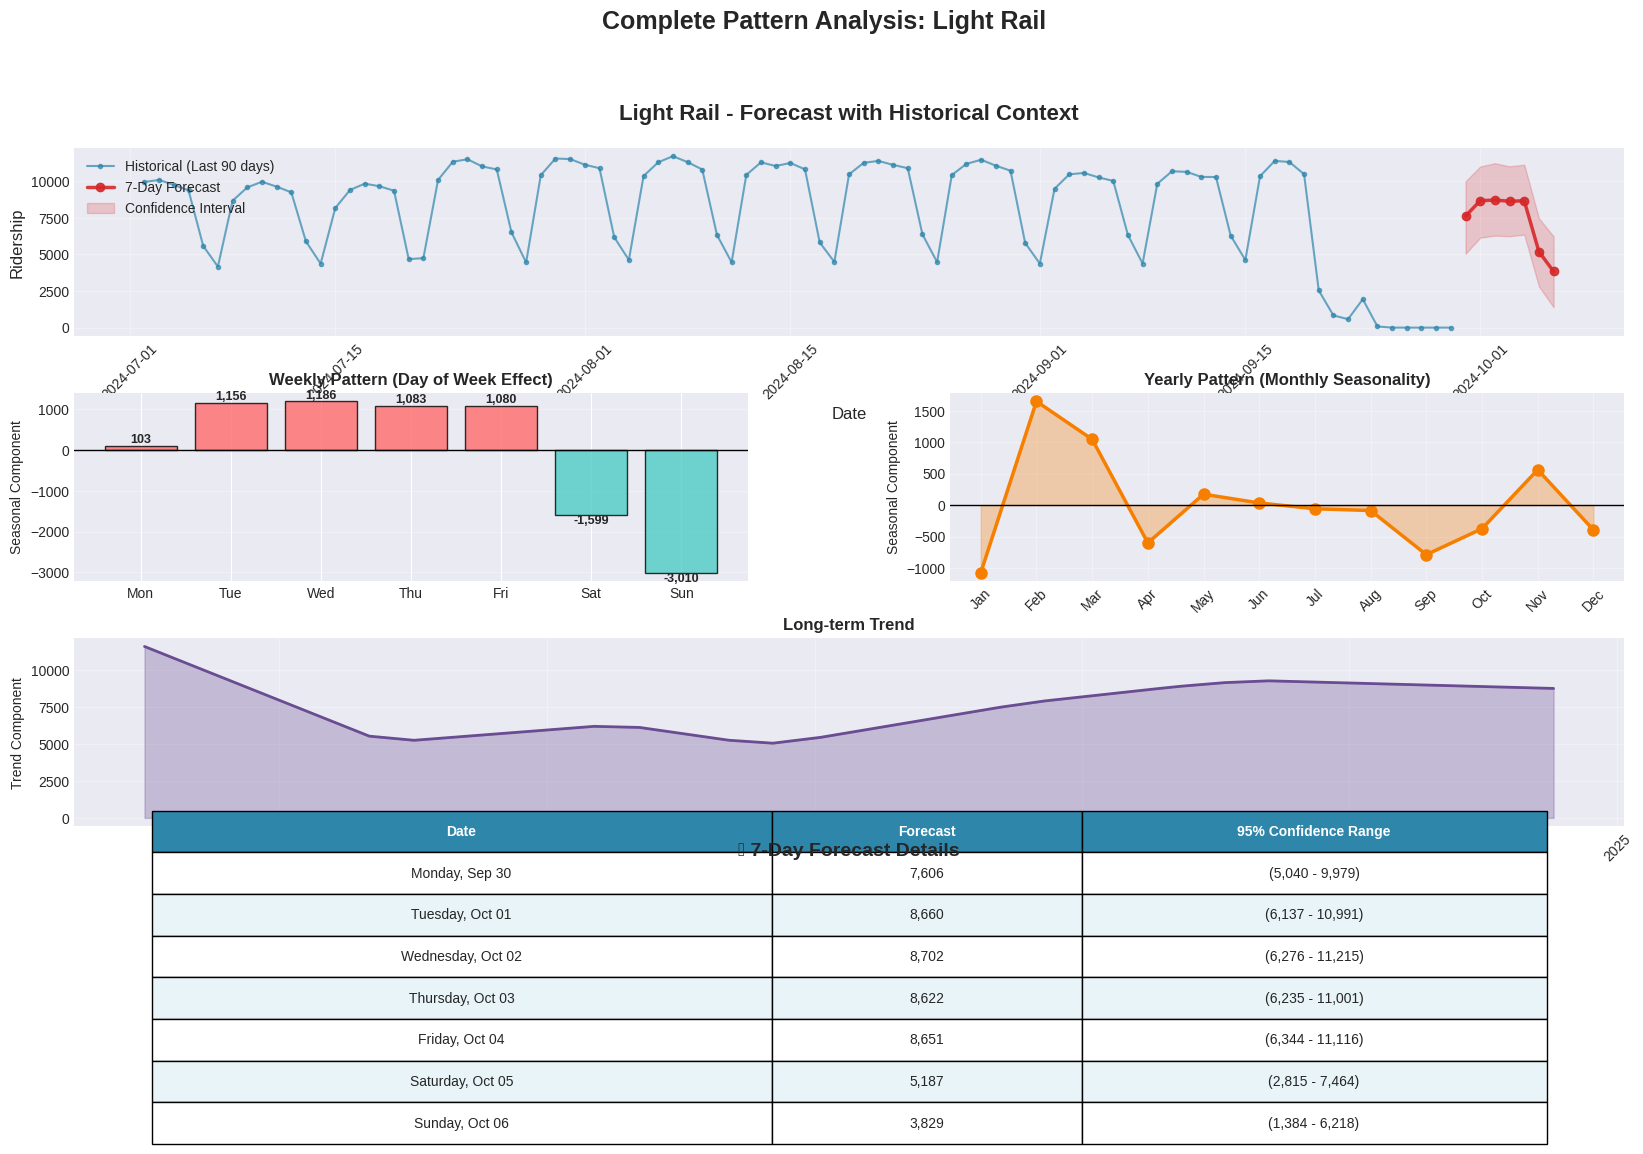


📊 Weekly Pattern:
  Highest ridership: Wed (+1,186)
  Lowest ridership:  Sun (-3,010)
  Weekend drop:      -2,304 (avg Sat-Sun)

📅 Monthly Pattern:
  Peak month:   Jan (+1,648)
  Lowest month: Dec (-1,076)

🔮 Next 7 Days:
  Average forecast: 7,323 riders/day
  Total forecast:   51,258 riders (7 days)


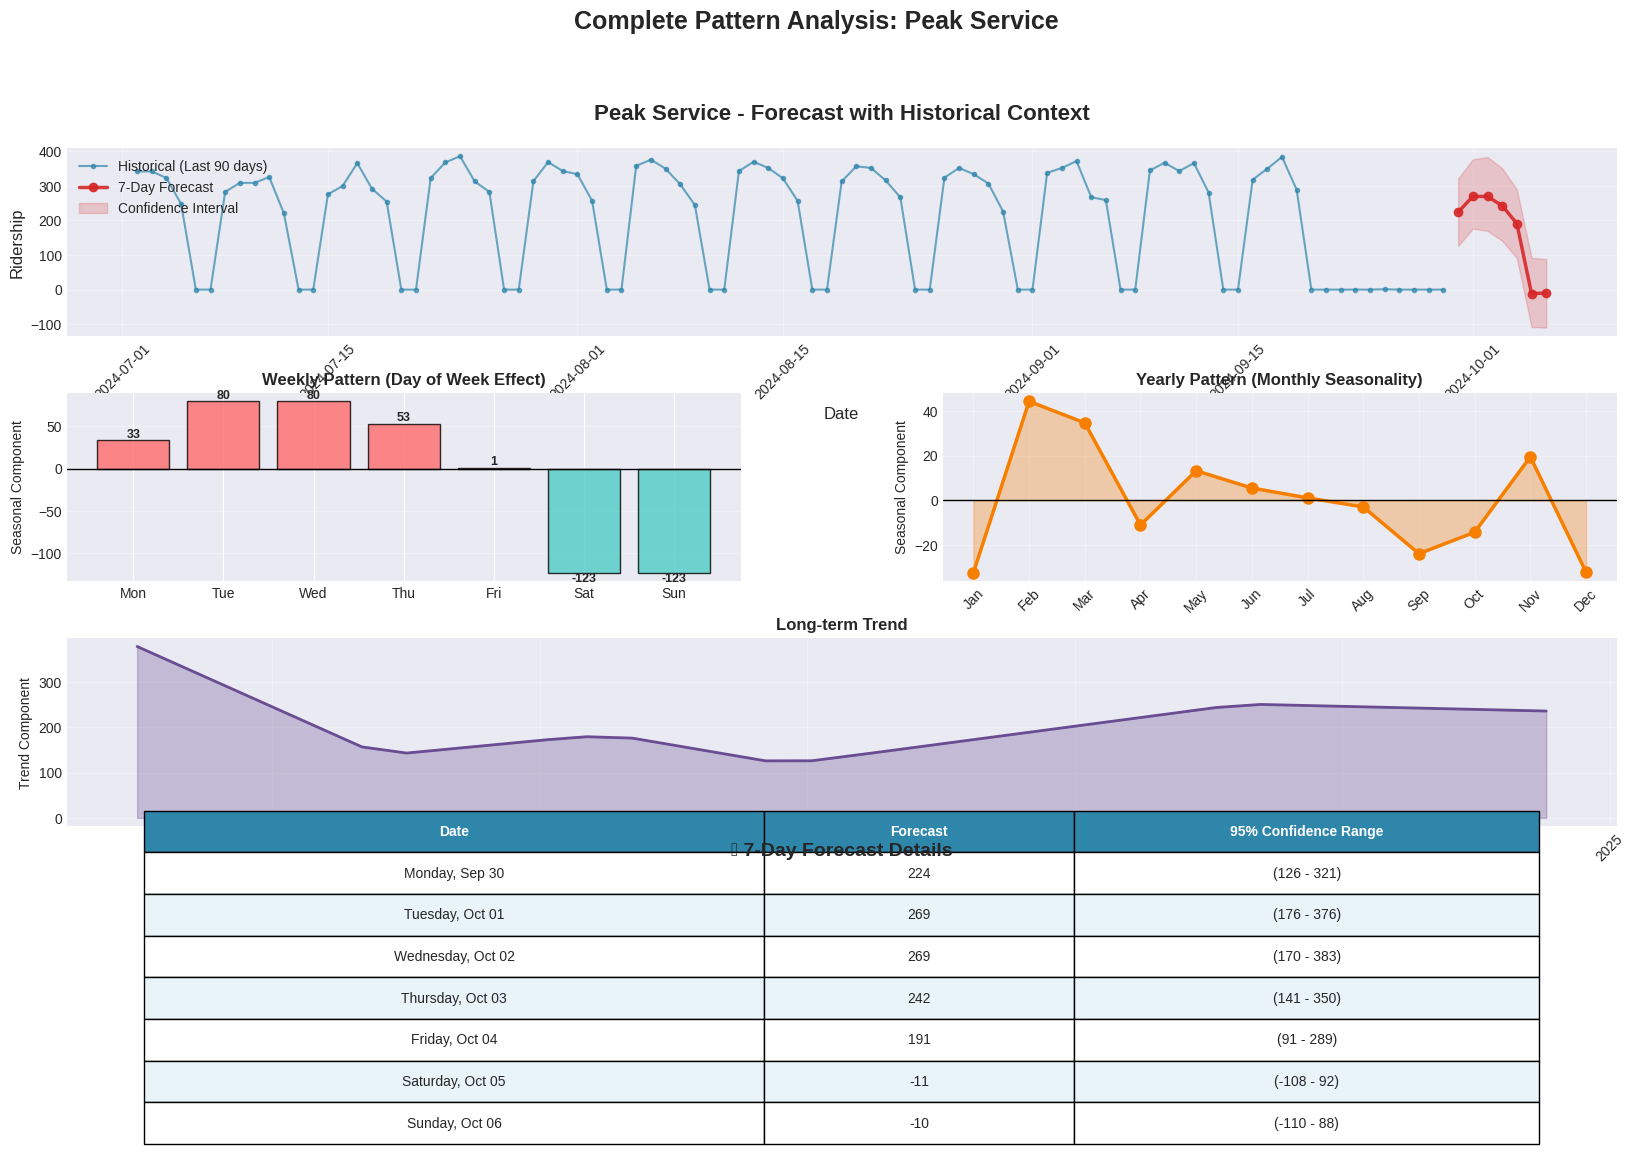


📊 Weekly Pattern:
  Highest ridership: Wed (+80)
  Lowest ridership:  Sat (-123)
  Weekend drop:      -123 (avg Sat-Sun)

📅 Monthly Pattern:
  Peak month:   Jan (+44)
  Lowest month: Dec (-32)

🔮 Next 7 Days:
  Average forecast: 168 riders/day
  Total forecast:   1,173 riders (7 days)


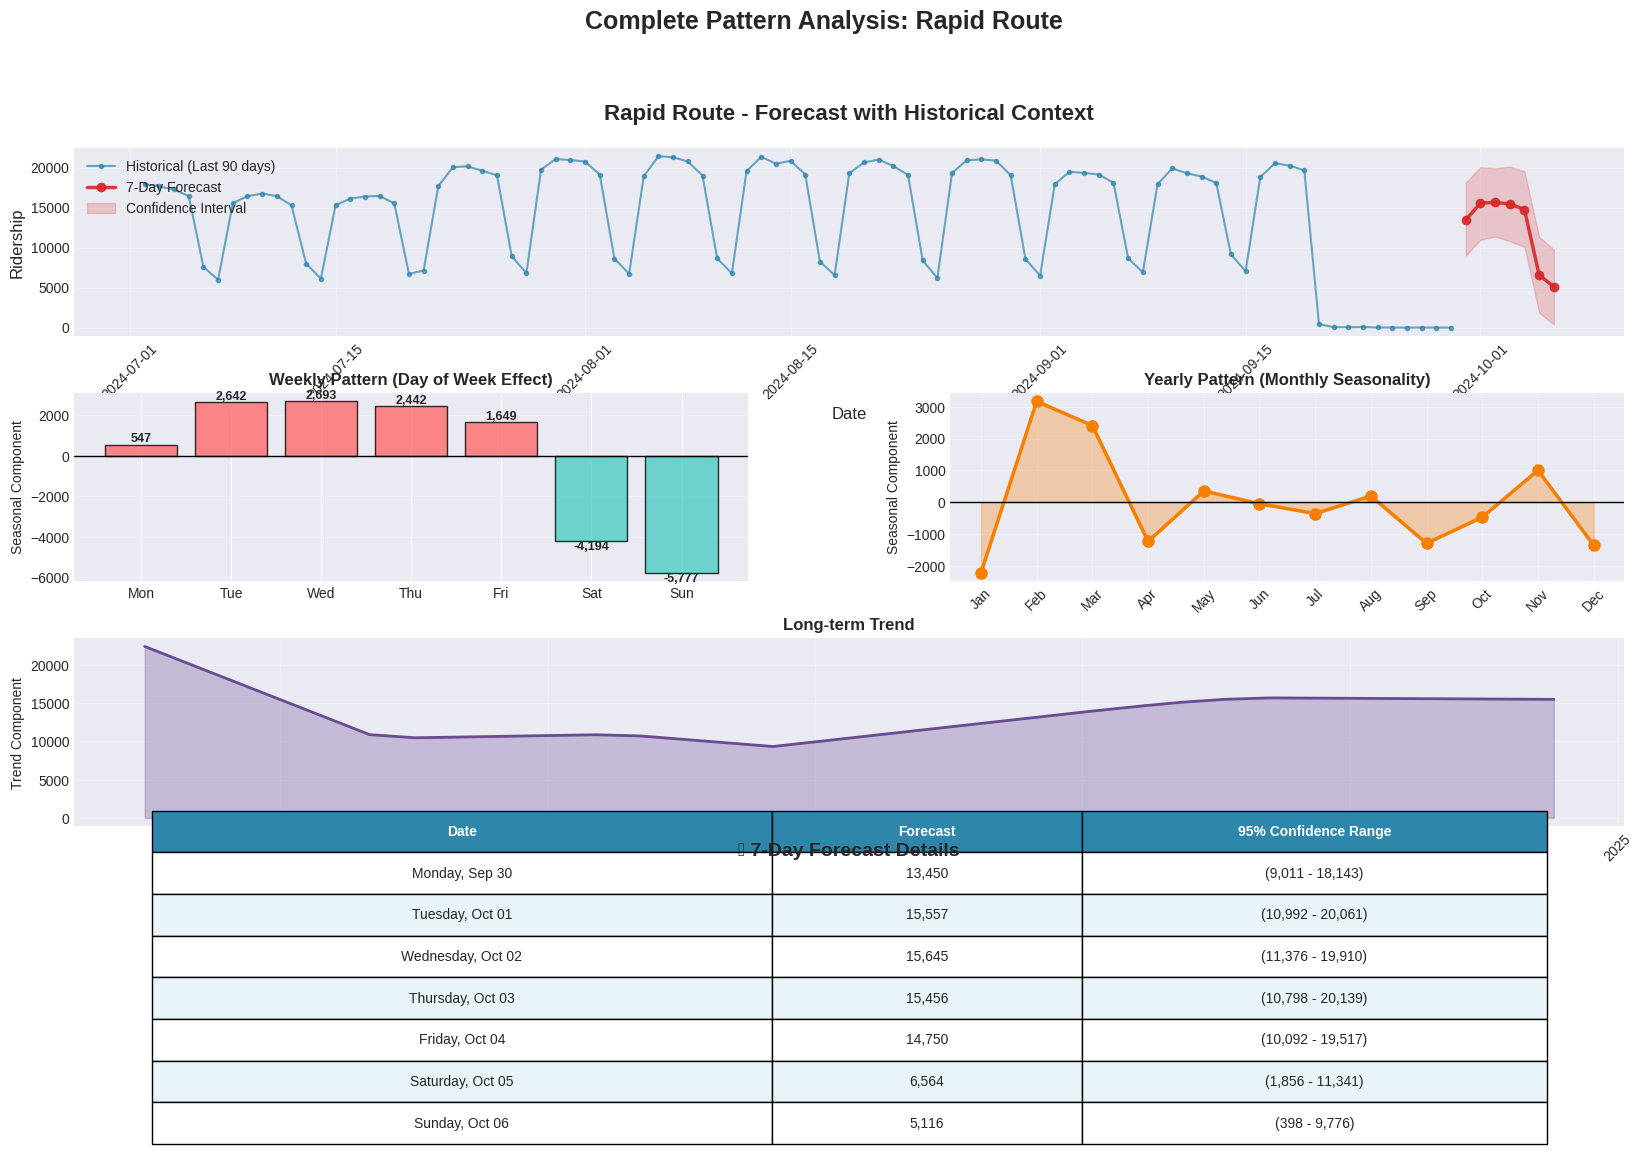


📊 Weekly Pattern:
  Highest ridership: Wed (+2,693)
  Lowest ridership:  Sun (-5,777)
  Weekend drop:      -4,986 (avg Sat-Sun)

📅 Monthly Pattern:
  Peak month:   Jan (+3,169)
  Lowest month: Dec (-2,220)

🔮 Next 7 Days:
  Average forecast: 12,362 riders/day
  Total forecast:   86,537 riders (7 days)


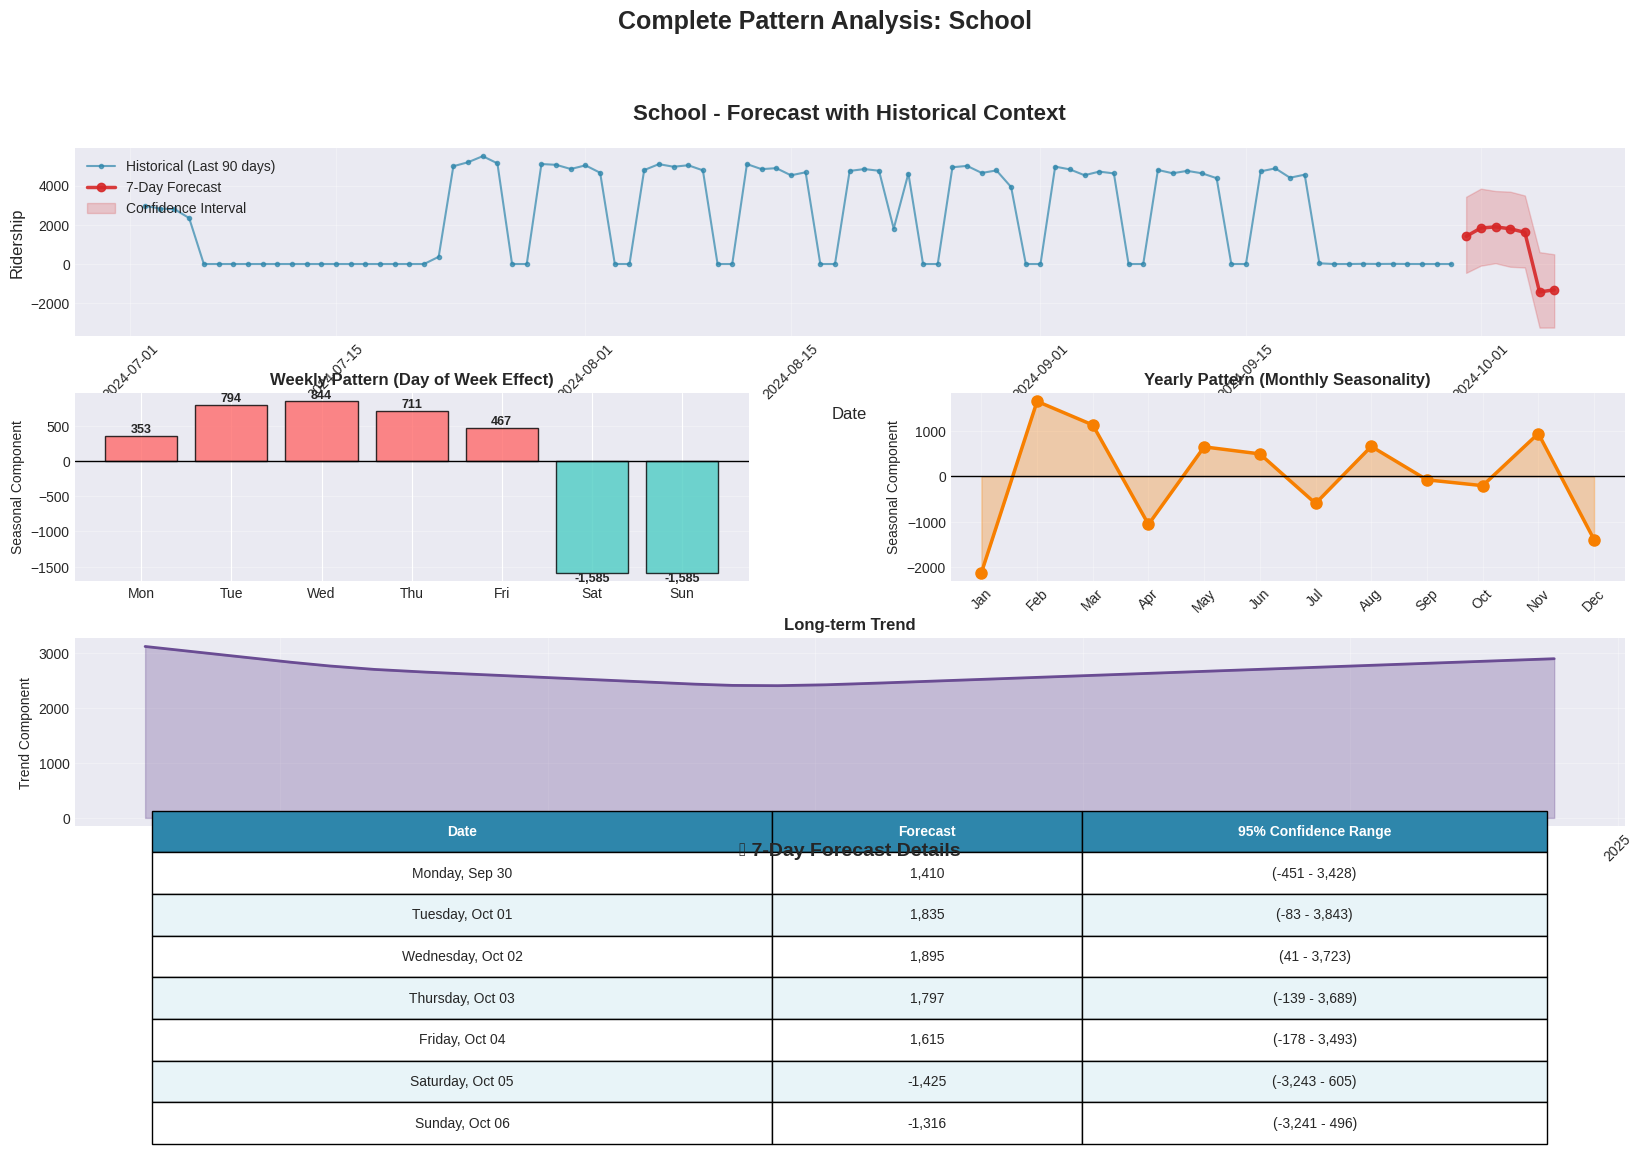


📊 Weekly Pattern:
  Highest ridership: Wed (+844)
  Lowest ridership:  Sat (-1,585)
  Weekend drop:      -1,585 (avg Sat-Sun)

📅 Monthly Pattern:
  Peak month:   Jan (+1,651)
  Lowest month: Dec (-2,122)

🔮 Next 7 Days:
  Average forecast: 830 riders/day
  Total forecast:   5,811 riders (7 days)
      Date  Local Route  Light Rail  Peak Service  Rapid Route       School
2024-09-30 10647.714377 7606.384113    223.560572 13449.846538  1410.490775
2024-10-01 12443.836854 8660.036164    268.997943 15557.395233  1834.519023
2024-10-02 12609.200435 8702.478287    268.764767 15644.833801  1894.945224
2024-10-03 12459.720021 8621.632482    242.211728 15455.875335  1797.232990
2024-10-04 11931.177809 8651.459760    190.551328 14749.575793  1614.993908
2024-10-05  2783.653953 5186.990088    -11.393039  6564.241118 -1424.627539
2024-10-06  1859.473888 3829.274566    -10.007194  5115.518402 -1316.247827


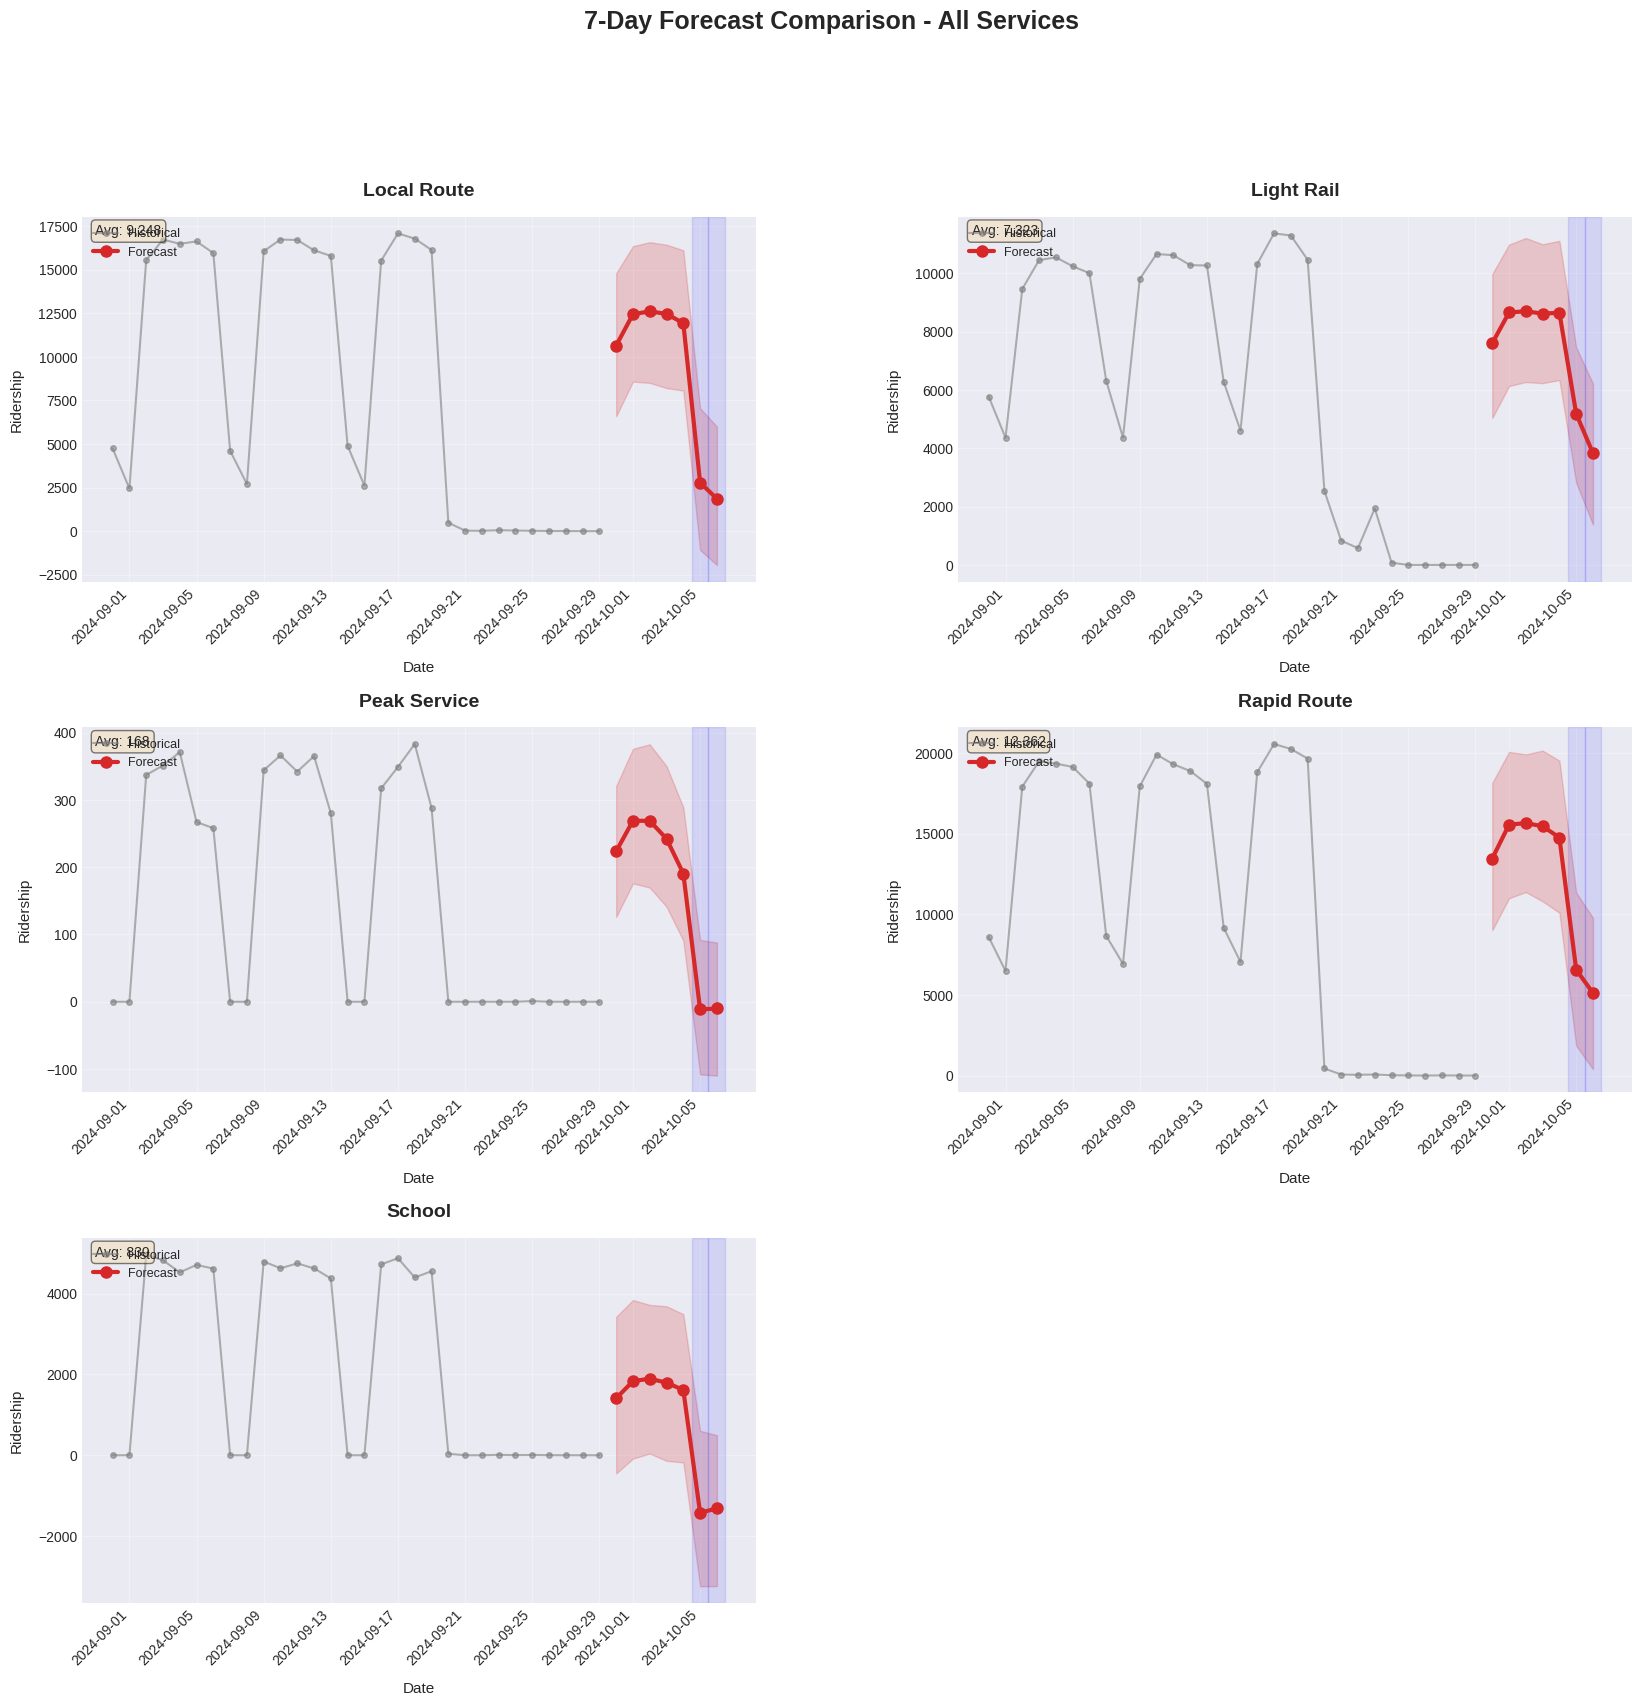

     Service Avg Daily Total 7-Day    Min    Max
 Local Route     9,248      64,735  1,859 12,609
  Light Rail     7,323      51,258  3,829  8,702
Peak Service       168       1,173    -11    269
 Rapid Route    12,362      86,537  5,116 15,645
      School       830       5,811 -1,425  1,895

All models have been built and evaluated.
Best performing model: Prophet

All patterns visualized with:
   Weekly seasonality (weekday vs weekend)
   Yearly seasonality (monthly variations)
   Long-term trends
   7-day forecasts with confidence intervals
   Comparative analysis across all service types


<Figure size 1200x800 with 0 Axes>

In [119]:
def visualize_service_patterns(model, forecast, train, column, df_original):
    """Create comprehensive pattern visualizations"""

    # 1. MAIN FORECAST PLOT
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)

    # Plot 1: Full forecast with historical data
    ax1 = fig.add_subplot(gs[0, :])

    # Historical data (last 90 days)
    recent_data = train.tail(90)
    ax1.plot(recent_data['ds'], recent_data['y'], 'o-',
             linewidth=1.5, markersize=3, label='Historical (Last 90 days)',
             color='#2E86AB', alpha=0.7)

    # 7-day forecast
    forecast_7d = forecast.tail(7)
    ax1.plot(forecast_7d['ds'], forecast_7d['yhat'], 'o-',
             linewidth=2.5, markersize=6, label='7-Day Forecast',
             color='#D62828', alpha=0.9)
    ax1.fill_between(forecast_7d['ds'],
                      forecast_7d['yhat_lower'],
                      forecast_7d['yhat_upper'],
                      alpha=0.2, color='#D62828', label='Confidence Interval')

    ax1.set_title(f'{column} - Forecast with Historical Context',
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Ridership', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

    # Plot 2: WEEKLY SEASONALITY
    ax2 = fig.add_subplot(gs[1, 0])
    weekly = forecast[['ds', 'weekly']].copy()
    weekly['day_of_week'] = weekly['ds'].dt.dayofweek
    weekly_avg = weekly.groupby('day_of_week')['weekly'].mean()

    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    colors_week = ['#FF6B6B' if i < 5 else '#4ECDC4' for i in range(7)]

    bars = ax2.bar(range(7), weekly_avg.values, color=colors_week, alpha=0.8, edgecolor='black')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xticks(range(7))
    ax2.set_xticklabels(days)
    ax2.set_title('Weekly Pattern (Day of Week Effect)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Seasonal Component', fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom' if height > 0 else 'top',
                fontsize=9, fontweight='bold')

    # Plot 3: YEARLY SEASONALITY
    ax3 = fig.add_subplot(gs[1, 1])
    yearly = forecast[['ds', 'yearly']].copy()
    yearly['month'] = yearly['ds'].dt.month
    yearly_avg = yearly.groupby('month')['yearly'].mean()

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax3.plot(range(1, 13), yearly_avg.values, 'o-',
             linewidth=2.5, markersize=8, color='#F77F00')
    ax3.fill_between(range(1, 13), yearly_avg.values, 0, alpha=0.3, color='#F77F00')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax3.set_xticks(range(1, 13))
    ax3.set_xticklabels(months, rotation=45)
    ax3.set_title('Yearly Pattern (Monthly Seasonality)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Seasonal Component', fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Plot 4: TREND
    ax4 = fig.add_subplot(gs[2, :])
    ax4.plot(forecast['ds'], forecast['trend'], linewidth=2, color='#6A4C93')
    ax4.fill_between(forecast['ds'], forecast['trend'], alpha=0.3, color='#6A4C93')
    ax4.set_title('Long-term Trend', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Trend Component', fontsize=10)
    ax4.set_xlabel('Date', fontsize=10)
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

    # Plot 5: 7-DAY FORECAST TABLE
    ax5 = fig.add_subplot(gs[3, :])
    ax5.axis('off')

    forecast_7d = forecast.tail(7)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    forecast_7d['day'] = forecast_7d['ds'].dt.strftime('%A, %b %d')
    forecast_7d['forecast'] = forecast_7d['yhat'].apply(lambda x: f'{x:,.0f}')
    forecast_7d['range'] = forecast_7d.apply(
        lambda row: f"({row['yhat_lower']:,.0f} - {row['yhat_upper']:,.0f})", axis=1
    )

    table_data = forecast_7d[['day', 'forecast', 'range']].values

    table = ax5.table(cellText=table_data,
                     colLabels=['Date', 'Forecast', '95% Confidence Range'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.4, 0.2, 0.3])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)

    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#2E86AB')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style rows (alternate colors)
    for i in range(1, 8):
        color = '#E8F4F8' if i % 2 == 0 else 'white'
        for j in range(3):
            table[(i, j)].set_facecolor(color)

    ax5.set_title('📅 7-Day Forecast Details', fontsize=14, fontweight='bold', pad=20)

    plt.suptitle(f'Complete Pattern Analysis: {column}',
                 fontsize=18, fontweight='bold', y=0.995)

    plt.tight_layout()
    plt.show()

    # Print summary statistics


    print(f"\n📊 Weekly Pattern:")
    print(f"  Highest ridership: {days[weekly_avg.argmax()]} ({weekly_avg.max():+,.0f})")
    print(f"  Lowest ridership:  {days[weekly_avg.argmin()]} ({weekly_avg.min():+,.0f})")
    print(f"  Weekend drop:      {weekly_avg[5:].mean():+,.0f} (avg Sat-Sun)")

    print(f"\n📅 Monthly Pattern:")
    print(f"  Peak month:   {months[yearly_avg.argmax()-1]} ({yearly_avg.max():+,.0f})")
    print(f"  Lowest month: {months[yearly_avg.argmin()-1]} ({yearly_avg.min():+,.0f})")

    avg_forecast = forecast_7d['yhat'].mean()
    print(f"\n🔮 Next 7 Days:")
    print(f"  Average forecast: {avg_forecast:,.0f} riders/day")
    print(f"  Total forecast:   {forecast_7d['yhat'].sum():,.0f} riders (7 days)")

def forecast_7_days(df, columns):
    """Generate 7-day forecasts for all service types using Prophet with detailed visualizations"""


    last_date = df['Date'].max()
    forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=7)

    forecasts = pd.DataFrame({'Date': forecast_dates})
    all_results = {}

    for col in columns:


        # Prepare data for Prophet
        prophet_df = pd.DataFrame({
            'ds': df['Date'],
            'y': df[col]
        })

        # Build Prophet model
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=10
        )

        # Add weekend regressor
        prophet_df['is_weekend'] = prophet_df['ds'].dt.dayofweek >= 5
        model.add_regressor('is_weekend')

        # Fit model
        model.fit(prophet_df)

        # Create future dataframe
        future = model.make_future_dataframe(periods=7)
        future['is_weekend'] = future['ds'].dt.dayofweek >= 5

        # Forecast
        forecast = model.predict(future)

        # Extract last 7 days (the future predictions)
        forecast_values = forecast['yhat'].tail(7).values
        forecasts[col] = forecast_values

        # Store results for visualization
        all_results[col] = {
            'model': model,
            'forecast': forecast,
            'train': prophet_df
        }

        # Visualize patterns for this service
        visualize_service_patterns(model, forecast, prophet_df, col, df)

    print(forecasts.to_string(index=False))

    # Create comparative visualization


    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    fig.suptitle('7-Day Forecast Comparison - All Services',
                 fontsize=18, fontweight='bold', y=0.995)

    # Add more space between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        forecast = all_results[col]['forecast']
        train = all_results[col]['train']

        # Last 30 days historical
        recent = train.tail(30)
        ax.plot(recent['ds'], recent['y'], 'o-',
               linewidth=1.5, markersize=4, alpha=0.6,
               color='gray', label='Historical')

        # 7-day forecast
        forecast_7d = forecast.tail(7)
        ax.plot(forecast_7d['ds'], forecast_7d['yhat'], 'o-',
               linewidth=3, markersize=8, color='#D62828',
               label='Forecast', zorder=10)
        ax.fill_between(forecast_7d['ds'],
                       forecast_7d['yhat_lower'],
                       forecast_7d['yhat_upper'],
                       alpha=0.2, color='#D62828')

        # Highlight weekends in forecast
        for date in forecast_7d['ds']:
            if date.dayofweek >= 5:
                ax.axvspan(date - pd.Timedelta(hours=12),
                          date + pd.Timedelta(hours=12),
                          alpha=0.1, color='blue')

        ax.set_title(f'{col}', fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel('Date', fontsize=11, labelpad=10)
        ax.set_ylabel('Ridership', fontsize=11, labelpad=10)
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(True, alpha=0.3)

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

        # Add forecast average
        avg_forecast = forecast_7d['yhat'].mean()
        ax.text(0.02, 0.98, f'Avg: {avg_forecast:,.0f}',
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Hide the 6th subplot if there are only 5 service types
    if len(columns) == 5:
        axes[5].axis('off')

    plt.show()

    # Print summary table


    summary_data = []
    for col in columns:
        forecast_7d = all_results[col]['forecast'].tail(7)
        summary_data.append({
            'Service': col,
            'Avg Daily': f"{forecast_7d['yhat'].mean():,.0f}",
            'Total 7-Day': f"{forecast_7d['yhat'].sum():,.0f}",
            'Min': f"{forecast_7d['yhat'].min():,.0f}",
            'Max': f"{forecast_7d['yhat'].max():,.0f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    return forecasts, all_results

# Generate 7-day forecasts using Prophet with detailed visualizations
forecasts, all_results = forecast_7_days(df, ridership_cols)


plt.subplots_adjust(
    top=0.93,
    bottom=0.06,
    hspace=0.55,     # increase vertical gap
    wspace=0.35
)

print("\nAll models have been built and evaluated.")
print(f"Best performing model: {best_model_name}")
print("\nAll patterns visualized with:")
print("   Weekly seasonality (weekday vs weekend)")
print("   Yearly seasonality (monthly variations)")
print("   Long-term trends")
print("   7-day forecasts with confidence intervals")
print("   Comparative analysis across all service types")

##